# Crime and Neural Nets
## Or: Introducing Recurrent Neural Networks with Long-Short-Term Memory and Gated Recurrent Unit to predict reported Crime Incidents
#### *Carolin Kunze, Marc Scheu, Thomas Siskos*


<img align="right" src="pics/crime_intro.png" alt="NN" style="width: 500px;"/>
Several police departments across the Unites States have been experimenting with software for crime prdiction. This  started a controversial debate: Critics are questioning the predictiv power of the underlying machine learning models and point out biases towards certain crime typs and neighborhoods. We took this as occacion to look into the publicly available <a href="https://catalog.data.gov/dataset/crimes-2001-to-present-398a4">crime records of the city of chicago</a>. The data set contains close to 7 milliom reported crime incidences starting from 2001 until the precceding week of the data download. It includes 22 columns with detailed information, such as type of the offence,  geo location,  district and the time of crime occurence. We will focus on temporal patterns in the data by predicting crime frequencies per day on the district level. Such a model may be used in practice to faciliate personel planning across the districts for the chigaco police force. We generate the input data for model building by counting the reported crimes by day and district. This results in a table with three columns containing date, district and the respective counts. 




In [1]:
import pandas as pd

data = pd.read_csv('../data/crimes_district.csv')
data.head()

,District,Date,Incidents
0,1.0,2001-01-01,37.0
1,1.0,2001-01-02,44.0
2,1.0,2001-01-03,44.0
3,1.0,2001-01-04,41.0
4,1.0,2001-01-05,67.0


By changing this aggregation on the time or the locational level a similar model for more granular predictions might be build. This is under the assumption of enough representative data on a more detailed aggregation level. We will take the described use case as an example to introduce Recurrent Neural Networks (RNNs) with Long-Short-Term memory (LSTM) and Gated Recurrent Unit (GRU). First we explain the general concept behind RNNs and train a simple network using different input formats. We then introduce RNNs with LSTM and GRU to overcome the vanishing gradient problem. After explaining the forward pass and the derivation of LSTM and GRU we tune the hyperparameters for the three introduced RNN variants and compare their performance.

### Introduction to Recurrent Neural Networks

Many machine learning tasks are based on the assumption of identically independent distributed (i.i.d.) samples. Thus a prediction for a label $y_i$ only depends on the corresponding feature vector $\vec{x_i}$, where $i$ denotes the index of the sample. When working with sequential data, one typically wants to predict a future outcome $\vec{y_{t+1}}$, which often equals the following observable vector $\vec{x_{t+1}}$, from a sequence of previously observed vectors $\vec{x_t}$, …, $\vec{x_{t-T}}$. $t$ denotes the last observed point of time and $T$  the number of observations since the start of the sequence.
While the vectors within a sequence are assumed to be dependent, we might still work with multiple mutually independent time series in a dataset. In this case one could use de notation $\vec{x_{ti}}$, corresponding to the observed vector at time $t$ from the sample sequence $i$. For simplicity we omit the sample index below. Note that many sequential prediction tasks are based on one dimensional time series, in that case one may also omit the vector notation. However, we stick to the more general form. <br>
A simple feedforward network may be used to make predictions under the i.i.d assumption by passing one feature vector $\vec{x_i}$ at a time through the network. However, if one wants to account for temporal dependencies between the observed vectors $\vec{x_t}$, …, $\vec{x_{t-T}}$ the network needs some kind of memory. That’s the concept behind recurrent neural networks: They use hidden activations, referred to as hidden state, to carry information within the network from one observation to the following one.


<img align="center" src="pics/RNN_t2.png" alt="NN" style="width: 500px;"/>
<p style='text-align: center;'>Image 1: Recurrent Neural Network with a sequence length of two.</p>

Image 1 illustrates how a simple RNN may be used to predict $\vec{y_{t+1}} (:= \vec{x_{t+1})} $ given a sequence of two observed vectors $\vec{x_t}$ and $\vec{x_{t-1}}$. The rectangles represent the input vectors. Each circle represents a vector of hidden activations and the triangle represents the output i.e. the predicted label. The arrows illustrate layer operations, i.e. the multiplication of the previous vector with one of the weight matrices $W_{in}$, $W_h$, or $W_{out}$, denoted by different colours. To make a prediction for $\vec{y_{t+1}}$, the first vector in the sequence $\vec{x_{t-1}}$ gets multiplied with the input weights $W_{in}$ and the activation function is applied to produce the first hidden state $\vec{h_{t-1}}$. Since $\vec{x_{t-1}}$ is the first observation in the sequence, $\vec{h_{t-1}}$ represents all available information at the time step $t-1$. To carry this information to the next hidden state $\vec{h_t}$, $\vec{h_{t-1}}$ gets multiplied with the hidden weight matrix $W_h$. Consecutively the new input $\vec{x_t}$ is multiplied with the input matrix $W_{in}$. The resulting vector carries the new information extracted from $\vec{x_t}$. This newly available information needs to be combined with the knowledge about previous observations to create $\vec{h_t}$. This can be done by summing up the two outputs from the matrix products and the bias $b_h$ and applying the  hyperbolic tangents as activation function to the vector sum (Equation 1). This is illustrated by the intersect of the green and the orange arrow. Conceptually the weights in $W_h$ represent the importance of previous observations and the weights in $W_{in}$ represent the importance of new information for the prediction task.
All available information at the time step $t$ is now aggregated in $\vec{h_t}$. To make a prediction for $\vec{y_{t+1}}$ it gets multiplied with the output weight matrix $W_{out}$ (Eqation 2). The size of $W_{out}$ and the corresponding activation function are, as usually, defined by the prediction task (regression or classification). This steps cover the forward pass in a simple RNN.
<br>
<br>
$\vec{h_t} = tanh(W_{in} * \vec{h_{t-1}} +  \vec{x_{t}} +\vec{b_{h}} )$  (Eqation 1)
<br>
$\vec{y_{t+1}} = ReLu(W_{out} * \vec{h_t} + \vec{b_{out}} )$ (Eqation 2)
<br>
<br>
If we want to look back more time steps when making a prediction for $\vec{y_{t+1}}$, we just need to add another hidden state and another input for every additional time step. Image 3 illustrates how this may look for a sequence of length three. Interestingly, even though RNNs can get quite deep along the time dimension, they have relatively few parameters. This is the case because all inputs or hidden states represent the same thing, another time step in the series or another aggregation of past observations. Thus, we only have to train three different weight matrices, one for the input, one for the hidden state and one for the output.<br>

<img  src="pics/RNN_t3.png" alt="NN" style="width: 550px;"/>
<p style='text-align: center;'>Image 2: Recurrent neural network with a sequence length of three.</p>

Drawing RNNs with more time steps becomes cumbersome. We have to keep adding inputs and hidden states. The same holds true if we would like to construct them in in python. A more elegant and flexible representation is given in Image 4. Compared to Image 3 the repetitive elements have been put into a loop. For every time step in the sequence length $T$, the new input is feed into the network and combined with the previous hidden state. The new hidden state is passed back to the start of the loop as input to the next iteration. The loop stops at the end of the sequence and the last hidden state is put through the output layer. To include the first timestep within the loop representation, an initial hidden state $\vec{h_0}$ is defined as a vector of zeros.


<img  src="pics/RNN_Loop.png" alt="NN" style="width: 350px;"/>
<p style='text-align: center;'>Image 3: Recurrent neural network with a loop and a sequence length of $T$.</p>


Keras provides a predefined model layer that constructs the described RNN behind the scenes. However, to emphasise the described operations, we demonstrate how to construct it by yourself using fully connected layers and the keras functional API. In keras a layer refers to a set of layer operations, typically a matrix multiplication and the application of an activation function, that output a new vector of activations. We follow this notation below.<br>
The functional  API allows to define a list of inputs and put them through several layers to produce a (list of) output(s). It then connects inputs and output(s) so the keras backend can be used to derive the gradients and train the model. We start implementing the RNN by initializing the `input_list`. The basic properties of a simple RNN are defined by the number of the hidden activations `H_SZ` , the sequence length `SEQ_LEN` and the number of features `FEAT_SZ` per time step. By choosing `H_SZ`, the shape of the three weight matrices is sufficiently defined: The second and first dimension of $W_{in}$ and $W_{out}$ are respectively defined by the shape of the input data and the labels. Moreover, the first dimension of $W_{in}$ must match the first dimension of $W_h$, so their outputs can be added together. $W_h$ must be squared because the result of the matrix product $W_h$ x $h_t$ gets again multiplied with $W_h$. Since $h_t$ gets also multiplied by $W_{out}$ the second dimension of $W_{out}$ must also be `H_SZ`. We set `H_SZ` to five and `SEQ_LEN` to ten after little manual tuning. In general, the parameters did not seem to have a great impact on the model performance. Since the crime data consists of one-dimensional time series `FEAT_SZ` is given as one.

In [2]:
import keras.backend as K
from keras import metrics

from keras.layers import Input, Dense, add, Activation, SimpleRNN, TimeDistributed
from keras.models import Model, Sequential


# create list to keep track of inputs
input_list = []

# initialize RNN properties
H_SZ = 5
SEQ_LEN = 10
FEAT_SZ = 1

Using TensorFlow backend.


The `Dense()` layer in keras holds the weights of a fully connected layer. It is initialized by passing the output dimension to the `Dense()` class. The input dimension will be interfered from the first input. After initialization, it can be called on a tensor which will return the resulting output activations. The three layers of the network are initialized by passing the respective number of output activations `H_SZ`, `H_SZ` and `FEAT_SZ` to the `Dense()` class.

In [3]:
# initilize fully connected layers and the activation function of the hidden state
first_layer = Dense(H_SZ, name = 'first_layer')
hidden_layer = Dense(H_SZ , name = 'hidden_layer')
tanh = Activation('tanh')
output_layer = Dense(FEAT_SZ, activation='relu', name = 'output_layer')

We  loop through the sequence length and create for every time step a new input `x` and append it to the input list. The input activations `act_in` are calculated for every time step by putting the input variable `x` through the first layer. We additionally initialize `h0` as a vector of zeros with the same (variable) shape as the input activations at the first time step. The new hidden state `ht` gets updated implementing Equation 1. After the loop the final hidden state is put through the output layer to make a prediction. Finally the functional API `Model()` connects input and output variables to create `myRNN`. Since keras typically works with tensors a function that splits a three-dimensional tensor along the second dimension, which corresponds to time dimension in keras, is defined.

In [4]:
for i in range(SEQ_LEN):
  
  # get input vector and append it to input list
  x = Input(shape = (FEAT_SZ,))
  input_list.append(x)
  
  # calculate input actiavtions
  act_in = first_layer(x)
  
  if(i == 0):
  # initialize h0 with zeros and append it to input list
    h0 = K.zeros_like(act_in)
    input_list.append(h0)  
    ht = Input(tensor = h0, name = 'h0')
  
  # calculate hidden activations
  ht = tanh(add([hidden_layer(ht), act_in])) 
  
# calculate output
out = output_layer(ht)

myRNN = Model(inputs=input_list, outputs=out)

In [5]:
def get_input(X):
  # slice 3-dim tensor along 2nd axis into list of inputs
  return([X[:,i,:] for i in range(X.shape[1])])

### Formatting sequential data

We load the reported crimes, counte by district and day and change the long-format in wide-format to get a matrix of 24 districts by 6513 timsteps.
By training one model on the time series from all districts, we assume each series to be a different realization of the same underlying sequential pattern. An obvious alternative would be to train a separate model for each district. 
Before further formatting we split the data into a train and a validation set. The validation set should resemble the data, the model would see in production. We therefore use the data from 2015 - 2017 as validation set. We will later use the most resent crime counts from 2017 as test set.
One can not simply train a neural network on 24 long time series.
It is common practice to split long time series into sub-sequences, treating them as independent samples. The simplest way to do this is, to slide a window of length `SEQ_LEN` through each series and treat each subseries contained in the window as one sample. The direct successor after the window defines the respective label for the sub-series (Image 4). 
Note that we will use the terms sample sequence and sub-sequence to a certain degree interchangable. Sample is used refering to the sequential counts in a row of the data matrix used for model training. Sub-sequence also refers to such a row, but it shall emphasis the row beeing a sub-sequence of a longer time series over the whole observation period.
<img align="center" src="pics/Format1.png" alt="NN" style="width: 500px;"/>
<p style='text-align: center;'>Image 4: Formatting data input for recurrent neural networks.</p>


In [6]:
full_seqs = data.pivot(index='District', columns='Date', values='Incidents')

In [7]:
dates = pd.to_datetime(full_seqs.columns)

lower = pd.to_datetime("2015-01-01")
upper = pd.to_datetime("2017-01-01")
end = pd.to_datetime("2018-01-01")

In [8]:
tr_idx = full_seqs.columns[dates < lower]
val_idx = full_seqs.columns[(dates >=lower) == (dates < upper)]

full_seqs_tr = full_seqs[tr_idx].values
full_seqs_val = full_seqs[val_idx].values

full_seqs_tr.shape, full_seqs_val.shape

((24, 5113), (24, 731))

We implement the sliding window by looping through the 24 full sequences and use array slicing withn a list comprehension to create the sub-sequences. The resulting sub-sequences are stacked vertically. Recurrent layers in keras and `MyRNN` above expect an input tensor of the dimensions `[batch_size, timesteps, input_dim]`. Since we work with one dimensional series, we have ignored the third dimension so far. In order to match the required input shape a thrid dimension of size one is added to the array.

In [9]:
def cut_sequences(long_seqs, SEQ_LEN):
  # input matrix of long sequences [sequences, timesteps]
  # returns matrix of subsequences X [subsequences, SEQ_LEN, 1], and labels y[subsequences,1]
  X = []
  y = []

  for long_seq in long_seqs:
    n = long_seq.shape[0]
    # slide window of SEQ_LEN over full sequence
    seq_stacked = np.stack([long_seq[i:i+SEQ_LEN] for i in range(n-SEQ_LEN)])
    labels = np.array([long_seq[i] for i in np.arange(SEQ_LEN, n)]).reshape(-1,1)
    X.append(seq_stacked)
    y.append(labels)

  X =  np.vstack(X)
  #add axis for number of features per time step = 1  
  X = X[:,:,np.newaxis]
  y =  np.vstack(y)
  
  return(X,y)

In [10]:
import numpy as np

# cut sequences in sub sequences of length SEQ_LEN
X_tr, y_tr = cut_sequences(full_seqs_tr, SEQ_LEN)
X_val, y_val = cut_sequences(full_seqs_val, SEQ_LEN)

X_tr.shape, y_tr.shape, X_val.shape, y_val.shape

((122472, 10, 1), (122472, 1), (17304, 10, 1), (17304, 1))

### Evaluation metric and benchmark
Before training a model one should consider how the prediction error may be evaluated w.r.t. the application objective. We use the mean squared error (MSE) as loss function, which is common for regression tasks. 
For user of the model, MSE is hard to interpret in the context of the model application. The mean absolute error (MAE) seems more interpretable: In combination with average crime counts it provides some intuition about the uncertainty included in model predictions. To get a basic feeling for model performance while building the model we establish as naive benchmark: We calculate the MAE using the last observed crime count as prediction for the succeeding crime count. This results in a MAE of 6.65.  Given the mean of 46 crimes per day and district this does not seem to bad for  a simple heuristic.

In [11]:
# naive benchmark: predict last observed count
AVG = y_tr.mean().round(3)
y_true = full_seqs_val[:,1:]
preds = full_seqs_val[:,:-1]

MAE_last_val = np.abs(preds - y_true ).mean().round(3)

print("Average daily crime count by district: " + str(int(AVG)))
print("MAE predict last value: " + str(MAE_last_val))

Average daily crime count by district: 46
MAE predict last value: 6.652


### Training
Like other neural networks, RNNs are trained trough back propagation. To derive the gradient for an RNN one must calculate the impact on the loss considering all inputs back to the first time step. This is called backpropagation through time (bptt). We look in more detail into the derivation when introducing the vanishing gradient problem and deriving the gradient for RNNs with Long-Short-Term Memory. Here we use the keras `.compile` method to pass the loss function, the optimizer and MAE as evaluation metric to `myRNN`.  <br>
We then train `myRNN`on the described input format. Subsequently we demonstrate a different data format using input and output sequences. We train two new models, one with and one without the `stateful` property. Subsequently we compare their training time and behaviour. Therfore we fit each model for 50 epochs, they converge relativ quickly, and save the results to a `Histroy` object. We focus on the concepts behind the models and their implementation. To keep things simple we use the same hyperparameter set for every model and briefly evaluate the MAE on the validation set over different epochs. We will look into more detail into hyperparameter tuning after introducing more complex RNNs with LSTM and GRU.

In [12]:
B_SZ = 30
EP =  50

myRNN.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
myRNN_hist = myRNN.fit(get_input(X_tr), y_tr, batch_size = B_SZ, epochs = EP , validation_data = (get_input(X_val), y_val), verbose = 0)

### Alternative formatting with prediction sequence

The way we created sample sequences so far, seems quite inefficient in terms of data usage: By sliding a window one step at time through the sequences we create mostly redundant sample sequences. A more efficient way of presenting data to the model is illustrated in Image 6. Instead of changing one value in each sample sequence, they are now defined by disjunct sub-sequences of lenght `SEQ_LEN`. Instead of predicting one label after observing a complete sub-sequence, we assigne a corresponding label sequences of the same length to each sample sequence. Each label sequence starts one time step ahead of the sample sequence.
The remaining values, i.e. the remainder of the full sequence length divided by `SEQ_LEN`, are dropped. This reduced the size of the data set by a factor of `SEQ_LEN`, without losing any information compared to the previous formatting.
<img align="center" src="pics/Format2.png" alt="NN" style="width: 500px;"/>
<p style='text-align: center;'> Image 5: Input format with prediction sequence.</p>

In [13]:
def cut_sequence_return_state(long_seqs, SEQ_LEN, cut_seq_start = True):
  long_seqs_X = long_seqs[:,:-1]
  long_seqs_y = long_seqs[:,1:]
  if(cut_seq_start):
    start = long_seqs_X.shape[1] % SEQ_LEN
    X = [long_seqs_X[:,i:i+SEQ_LEN] for i in np.arange(start,long_seqs_X.shape[1],SEQ_LEN)]
    y = [long_seqs_y[:,i:i+SEQ_LEN] for i in np.arange(start,long_seqs_y.shape[1],SEQ_LEN)]
  else:
    start = 0
    X = [long_seqs_X[:,i:i+SEQ_LEN] for i in np.arange(start,long_seqs_X.shape[1],SEQ_LEN)]
    y = [long_seqs_y[:,i:i+SEQ_LEN] for i in np.arange(start,long_seqs_y.shape[1],SEQ_LEN)]
    if X[-1].shape[1] != SEQ_LEN:
      X.pop()
      y.pop()
    
  X = np.vstack(X)[:,:,np.newaxis]
  y = np.vstack(y)[:,:,np.newaxis]
  return X, y

X_tr, y_tr = cut_sequence_return_state(full_seqs_tr, SEQ_LEN)
X_val, y_val = cut_sequence_return_state(full_seqs_val, SEQ_LEN, cut_seq_start = False)

We now replace `myRNN` by the keras `SimpleRNN()` layer in combination with a `Dense()` output layer. While this implements the same behaviour as `myRNN` it allows for additional functionality. By setting the `return_sequence` parameter to true it passes all hidden states, not only the last one, to the following layer. In the `myRRN` code above, this could have been implemented, by appending all hidden states to a list instead of updating the variable `ht`. The hidden states within the list are then passed through the output layer. The outputlayer returns for every time step in this hidden state sequence a prediction for the following time step in the label sequence. To implement this above, the output layer may be included in de loop (Image 3). The predictions then need to be save in a new output list. In keras this can be done more conviniently, by wrapping the output layer in the `TimeDistributed()` Wrapper. Image 9 shows the unrolled illustration of an RNN predicting sequences.
<img align="center" src="pics/RNN_Ret_Seq.png" alt="NN" style="width: 500px;"/>
<p style='text-align: center;'> Image 6: Recurrent neural network with return sequence</p>


In [14]:
# simple RNN with return sequence
model = Sequential()
model.add(SimpleRNN(H_SZ, input_shape=(SEQ_LEN,FEAT_SZ), return_sequences=True) )
model.add(TimeDistributed(Dense(FEAT_SZ)))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
seqRNN_hist = model.fit(X_tr, y_tr, batch_size = B_SZ,  epochs = EP, validation_data = (X_val, y_val), verbose = 0)

### Stateful recurrent neural networks
When comparing Image 6 and Image 2 you may notice a disadvatage of the return sequence formatting: In both cases, when making a prediction for $y_{t+1}$ the network has seen the inputs $x_{t-2}$, $x_{t-1}$ and $x_{t}$. When using a return sequences to make a prediction for $y_{t-1}$ in Image 6 the only network input is $x_{t-2}$. The hidden state has been initialized with zeros. Therefore we might suspect the error for the predictions on the beginning of the sequence to be higher than at the end. This problem occurs because we need to cut the full sequences into sub-sequences treated as independet samples. One way to avoid that is by saving the last hidden state of one sub-sequence and use it as inizialization of $h_{t}$ when passing the following subsequence (from the initial full sequence) through the network. In keras this can be done by setting the `stateful` parameter of the RNN to true. To memorize which subsequences belongt to the same district the batch size is used. It needs to be set equal to the number of independen full series, e.g here the number of districts. Note that the return sequence formatting is ordered by time and district: The first sub-sequence of the first district is in the first row and the first sub-sequence of the second district in the second row. The 25th row contains the second sub-sequence of the first district and so on. The samples within on batch get passed through the network in paralell. Thus the last hidden state of one row index in a batch is used to initialize the initial hidden state of the same row index in the next batch. When calling the `.fit` method keras shuffles the rows in the training data by defaul at the beginning of every training epoch. To make use of the stateful property the `shuffle` is set to false. Moreover the hidden states needs to be reset after every epoch. Otherwise the hidden state of the last time step of the full sequence would be passed on to the first time step at the next epoch. To do this we train the network in a for loop one epoch at a time and reset the state. 

In [15]:
# stateful RNN
B_SZ = 24

model = Sequential()
model.add(SimpleRNN(H_SZ, batch_input_shape=(B_SZ, SEQ_LEN, FEAT_SZ), return_sequences=True, stateful=True))
model.add(TimeDistributed(Dense(FEAT_SZ)))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])

In [16]:
stateful_val_mae = []
stateful_loss = []
stateful_val_loss = []

for i in range(EP):
    stateRNN_hist = model.fit(X_tr, y_tr, batch_size = B_SZ, epochs = 1, validation_data = (X_val, y_val), verbose = 0, shuffle=False)
    model.reset_states()
    stateful_val_mae.append(stateRNN_hist.history['val_mean_absolute_error'])
    stateful_loss.append(stateRNN_hist.history['loss'])
    stateful_val_loss.append(stateRNN_hist.history['val_loss'])

### Comparing training behaviour

When training a stateful RNN it is important to understand that the value of the last state is simply copied to the initial hidden state of the next subsequence. This may improve the prediction error, but when deriving the gradient, they are treated as constant. The inputs considered when updating the weights are still restricted to the sub-sequence length. Therefore, [some practitioners](https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html) argue that "unstateful” RNNs achieve in many application better results. Reasons for this include the loss of randomness by stopping to shuffle the data between epochs and the fixed batch size, which is a parameter to which RNNs might be sensitive.
[Brownlee](https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/) gives as a rule of thumb to use stateful RNNs when the output mainly depends on the occurence of a certain input. This may be the case in many natural language tasks. If the outputs represent a complex function of the previous time steps, increasing the subsequence length may be necessary instead. We will evaluate the behaviour of the MAE for the three models on the validation set over the training epochs. <br>


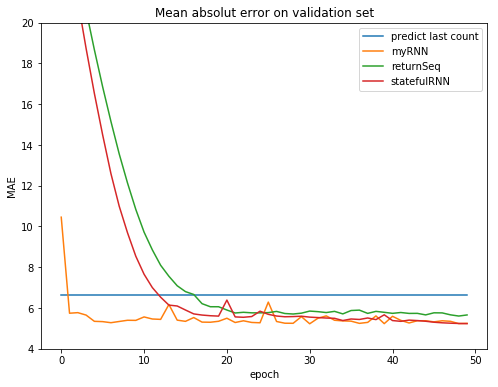

In [19]:
import matplotlib.pyplot as plt

plt.plot(np.repeat(MAE_last_val,50))
plt.plot(myRNN_hist.history['val_mean_absolute_error'])
plt.plot(seqRNN_hist.history['val_mean_absolute_error'])
plt.plot(stateful_val_mae)

plt.title('Mean absolut error on validation set')
plt.ylabel('MAE')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([4,20])
plt.rcParams["figure.figsize"] = (8, 6) # (w, h)

plt.legend(['predict last count', 'myRNN', 'returnSeq', 'statefulRNN'], loc='upper right')
plt.plot()
plt.show()

The first thing to notice is, that `myRRN` converges clearly faster than the two other models. It reaches already after the first epoch an MAE around six. This makes sense because the size of the training set was ten times bigger. However the `seqRNN` has not converged after ten epochs. So basically we make up for the reduced redundancy in the new data format by training for more epochs. 
All models perform better than the naive benchmark of 6.65. However, the improvment seems moderate given the additional model complexity. `seqRNN` and `statefulRNN` seem to converge against a value above five, while `seqRNN` only reaches a value close to six. The higher value of `statefulRNN` was expected due to the missing information at the start of the sample sequences. The stateful property could reduce the MAE back to the level of `myRNN` but it does not clearly improve it. Due to this result and the additional restrictions when building a stateful model we continue to work with the "stateless" variant and the first data format.<br>
So far we have been using a relativ small `SEQ_LEN` of ten. A simpler way of providing more information on past observations than the stateful option would be to increase the sample sequence length. We have not considered that so far because simple RNNs are hard to train on long sequences. The reason for this is the vanishing gradient problem.

### The Vanishing Gradient Problem

Even though RNNs cover the memory problem of simple neural networks, in practice we still face issues. The introduced Simple RNNs do have problems with long-term dependencies which they seem to forget.

Let us have a look at the following sentence as a sequence.

##### “In France, I had a great time and I learnt some of the ...? [language]" 

In this case, we would need the word "France" to remember to later on predict the word "French" at the end of the sentence. RNNs will have problems to still refer to the word "France" although they consider the previous timesteps in the current one. This problem refers to the so called vanishing (or exploding) gradient problem which is captured in the formulas below. In practice this means that crucial information of very far back timesteps do not have an influence on the current or future timesteps anymore or that irrelevant information gets too much influence.
 
<img src="pics/vanishing_gradient.png" alt="vanishing_gradient" style="width: 600px;"/>
<br>

[(Olah, 2015)](http://colah.github.io/posts/2015-08-Understanding-LSTMs)


During backpropagation through time the gradient of the loss function can be represented as follows.

$$\frac{\partial J_t}{\partial W_{in}} =\frac{\partial J_t}{\partial y_{t}}\frac{\partial y_t}{\partial h_{t}}\frac{\partial h_t}{\partial h_{t-1}}
\frac{\partial h_{t-1}}{\partial h_{t-2}}\space\space ...\frac{\partial h_{0}}{\partial W_{in}}$$

It can be shown that as the gap between the timesteps gets bigger the product of the gradients of the hidden states w.r.t. the previous states
$$\frac{\partial h_t}{\partial h_{t-1}}\frac{\partial h_{t-1}}{\partial h_{t-2}}\frac{\partial h_{t-2}}{\partial h_{t-3}}\space\space...$$
<br>
gets longer and longer and a lot of very small numbers are multiplied. This can also be seen in the following equation. Since the weights $W_in$ are sampled from a standard normal distribution this term will mostly be smaller than one. Similarly, the absolute value of the tanh will also be between zero and one. [(Suresh, 2017)](http://introtodeeplearning.com/2017/Sequence%20Modeling.pdf)


$$\frac{\partial h_t}{\partial h_{t-1}}
= W_{in}^T diag[tanh^{ `}(W_{in}+W_h x_j)]$$



### Literature Review

As suggested by [(Fischer et. al, 2017)]( https://www.econstor.eu/bitstream/10419/157808/1/886576210.pdf) one can make good use of an LSTM network for financial market prediction since it is a state-of-the art technique for sequence learning. Even though this is not the same domain as our crime use case, the authors of the paper still demonstrate that LSTM networks can extract relevant information from the underlying noisy data. The LSTM network was primarily introduced by [(Hochreiter and Schmidhuber, 1997)](https://www.bioinf.jku.at/publications/older/2604.pdf) to overcome the vanishing gradient problem and to learn long-term dependencies since the simple RNN is not capable of doing that. We know that predicting crime rates is not the typical use case for introducing LSTM and GRU networks. Nevertheless, our crime data is also sequential since we are looking at a certain period of time to predict the future crime incidences and in addition, we expect to need the capability of learning long-term dependencies. Furthermore, there have already been some successful approaches forecasting crime with LSTM networks [(Stec et. al, 2018)](https://arxiv.org/pdf/1806.01486.pdf). The Gated Recurrent Unit network, which is also a Recurrent Neural Network, is also getting more and more popular for the task of prediction when having sequential data. It was only introduced a few years ago [(Cho et. al, 2014)](https://arxiv.org/pdf/1406.1078.pdf ) and it has been shown that the GRU performs similar or even better, depending on the data and the setup. For instance, traffic flow has been predicted by an LSTM and a GRU network whereby the GRU performed slightly better than the LSTM model [(Fu et. al,  2016)](https://www.researchgate.net/profile/Li_Li240/publication/312402649_Using_LSTM_and_GRU_neural_network_methods_for_traffic_flow_prediction/links/5c20d38d299bf12be3971696/Using-LSTM-and-GRU-neural-network-methods-for-traffic-flow-prediction.pdf). That is why usually both models are built to see which one performs better in the given use case
[(Nguyen, 2018)](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21).

### Advanced RNNs: LSTMs and GRUs

<img src="pics/overview_RNN_LSTM_GRU.png" alt="LSTM" style="width: 800px;"/>

[(Tch, 2017)](https://towardsdatascience.com/the-mostly-complete-chart-of-neural-networks-explained-3fb6f2367464)

As already suggested, there are more advanced solutions than the simple RNN for the prediction of the next step in a sequence. To overcome the problem of the vanishing (and exploding) gradient, i.e. having crucial information in a very far back timestep that might vanish or irrelevant information might happen to have too much influence on the current time step, we suggest to use LSTM (Long Short-Term Memory) and the GRU (Gated Recurrent Unit) networks. In the following, we will tackle these popular approaches. Instead of the RNN cells the LSTM and GRU have more complex cells in the hidden states. The idea is to control the information flow and regulate what is passed through and what not and decide what the relevant information is from the current as well as the previous timestep. This is done by the different gates in the gated cells. 

### LSTM Networks - Long Short-Term Memory Networks

<img src="pics/LSTM.png" alt="LSTM" style="width: 800px;"/>

The LSTM is a special type of RNN which can learn long-term dependencies. Instead of having only one tanh layer as in the RNN, more layers as can be seen as the yellow rectangles. The LSTM has 3 gates which are represented as the sigmoid layers. The output of sigmoid function is alsways something in between zero and one, i.e. to decide if information is let through or not. We will refer to Christopher Olah's graphics and explanations in this part [(Olah, 2015)](http://colah.github.io/posts/2015-08-Understanding-LSTMs). Let us walk you through the complex LSTM cell step by step.

<img src="pics/lstm_core_idea.png" alt="LSTM" style="width: 400px;"/>

There is always a horizontal line running through all cells between the previous cell state $C_t-1$ and the current cell state $C_t$ and in between there happen a few interactions. A very important fact about the LSTM cell is that there is the cell state on the one hand which is often referred to as a memory. On the other hand, there is also a hidden state which is often referred to as the output. One can maybe think of the hidden state $h_t$ as a filtered version of the cell state, whereas the cell state has the ability to hold on to information that is not necessary for the current output. For instance, when we want to output the next word, we might not need all the information of this word to output but maybe we want to save the information of this word, such as if it is singular or plural or a noun or a verb, to predict words in a future timestep. 
Therefore, the cell state can hold on to information that might be useful in upcoming timesteps. 

The key things for now are that we have three gates in the LSTM cell and that the hidden state is separate from the cell state. Furthermore, by the gates information can be removed or added from the cell state.

In [3]:
# Initialize sample data and weights

import numpy as np

x = np.array([0.2, 0.3, 0.4])
y = 7.0

Wi = np.array([[3.1], [0.1]])
Ui = np.array([[1.5,2.6], [2.1,0.2]])

Wf = np.array([[2.3], [0.2]])
Uf = np.array([[3.6,4.1], [1.0,0.9]])

Wo = np.array([[0.1], [3.1]])
Uo = np.array([[0.1,0.9], [0.7,4.3]])

Wc = np.array([[0.2], [0.4]])
Uc = np.array([[1.8,3.6], [4.7,2.9]])

w = np.array([2.0,4.0])

h0 = np.array([0.0,0.0])

### The Forget Gate

<img src="pics/lstm_forget.png" alt="LSTM" style="width: 700px;"/>

First, there is a forget gate which decides what information to forget or even to leave everything through as it is.
As input the output of the previous cell $h_t-1$ and input of the current timestep are fed into the cell. The output will be something in between zero and one, i.e. one means that everything is kept from the previous timestep whereas zero means that everything from the previous timestep will be forgotten.

In [4]:
inner_f1 = np.dot(Wf,x[[0]])+ np.dot(Uf,h0)

f1 = 1/(1+np.exp(-inner_f1))
f1

array([0.61301418, 0.50999867])

### The Input Gate

<img src="pics/lstm_input.png" alt="LSTM" style="width: 700px;"/>


In the next step, it will be decided selectively what information to update in the cell state. This is done in two steps. First, it is determined which values to update and second, the vector with the values of the new candidates for the cell state is calculated.

In [5]:
inner_i1 = np.dot(Wi,x[[0]]) + np.dot(Ui,h0)

i1 = 1/(1+np.exp(-inner_i1))
i1

array([0.65021855, 0.50499983])

In [6]:
inner_c1_tilde = np.dot(Wc, x[[0]]) + np.dot(Uc, h0)

c1_tilde = np.tanh(inner_c1_tilde)
c1_tilde

array([0.03997868, 0.07982977])

### The Update of the Cell State

<img src="pics/lstm_new_cell_state.png" alt="LSTM" style="width: 600px;"/>

Now, the new cell state can be computed as follows. The cell state of the previous timestep is multipliead by the values we want to forget, i.e. this first term of the equation gives us the part, that we want to remember from the previous timestep. Then, one adds the proportion determined by the input gate (of what we want to update) of the values of the new candidates. Basically, this is about how much is kept from the previous cell state and how much we take from the candidates for the new cell state to actually calculate the cell state of timestep t. 

In [7]:
c0 = np.array([0.0,0.0])

c1 = f1 * c0 + i1 * c1_tilde
c1

array([0.02599488, 0.04031402])

### The Output Gate

<img src="pics/lstm_output.png" alt="LSTM" style="width: 600px;"/>

So what is the ouput of the cell? Basically, it is a filtered version of the cell state. The sigmoid layer (the output gate) filters what parts of the cell state will be included in the output $h_t$. The cell state is put through a tanh layer and ultimately multiplied by the values of the output gate. Thus, the output is a filtered version of the cell state.

In [8]:
# outpute gate
inner_o1 = np.dot(Wo, x[[0]]) + np.dot(Uo, h0)

o1 = 1/(1+np.exp(-inner_o1))
o1

array([0.50499983, 0.65021855])

In [9]:
h1 = o1 * np.tanh(c1)
h1

array([0.01312445, 0.02619873])

Now, that we know how to calculate all the values of one time step in an LSTM cell, we can just plug in the new updated values of the input $x_t$, the hidden state $h_{t-1}$ and the cell state $c_t$ for the second and third time step into the same equations. Usually, one would implement this in a loop, but for the purpose of demonstration we show you the steps in detail.

### Second time step

In [10]:
# forget gate 
inner_f2 = Wf.dot(x[[1]])+ Uf.dot(h1)
f2 = 1/(1+np.exp(-inner_f2))

# input gate
inner_i2 = Wi.dot(x[[1]]) + Ui.dot(h1)
i2 = 1/(1+np.exp(-inner_i2))

inner_c2_tilde = Wc.dot(x[[1]]) + Uc.dot(h1)
c2_tilde = np.tanh(inner_c2_tilde)

# update of the cell state
c2 = f2 * c1 + i2 * c2_tilde

# output gate
inner_o2 = Wo.dot(x[[1]]) + Uo.dot(h1)
o2 = 1/(1+np.exp(-inner_o2))

h2 = o2 * np.tanh(c2)
h2

array([0.07524102, 0.11116973])

### Third time step

In [11]:
# forget gate 
inner_f3 = Wf.dot(x[[2]])+ Uf.dot(h2)
f3 = 1/(1+np.exp(-inner_f3))

# input gate
inner_i3 = Wi.dot(x[[2]]) + Ui.dot(h2)
i3 = 1/(1+np.exp(-inner_i3))

inner_c3_tilde = Wc.dot(x[[2]]) + Uc.dot(h2)
c3_tilde = np.tanh(inner_c3_tilde)

# update of the cell state
c3 = f3 * c2 + i3 * c3_tilde

# output gate
inner_o3 = Wo.dot(x[[2]]) + Uo.dot(h2)
o3 = 1/(1+np.exp(-inner_o3))

h3 = o3 * np.tanh(c3)
h3

array([0.28170128, 0.37065888])

### Prediction

After running through all the time steps, we predict our target variable.

In [12]:
y_ = w.dot(h3)
y_

2.046038096901425

### GRU Networks - Gated Recurrent Unit Networks

<img src="pics/GRU.png" alt="GRU" style="width: 600px;"/>

[(Olah, 2015)](http://colah.github.io/posts/2015-08-Understanding-LSTMs)

The GRU network is a variation of the LSTM network and looks similar. Instead of having three gates, it only has two gates, the update and the reset gate which also work similar to the gates in the LSTM cell. 

In [13]:
# Initialize sample data and weights

x = np.array([0.2, 0.3, 0.4])
y = 7.0

Wz = np.array([[0.1], [3.1]])
Uz = np.array([[0.1,4.1], [0.2,1.0]])

Wr = np.array([[2.3], [0.5]])
Ur = np.array([[1.3,7.1], [9.1,4.5]])

Wh = np.array([[0.2], [0.9]])
Uh = np.array([[1.5,2.6], [1.8,3.6]])

w = np.array([2.0,4.0])

As input, the cell gets the input of the current timestep and the previous output $h_t-1$. An important difference to the LSTM is that there is no separate cell state: the hidden state and cell state are kind of "merged" so that there only remains a hidden state $h_t$.

### Update Gate

In the update gate $z_t$ it is determined what values to update from the past and the reset gate decides what information should be reset, i.e. removed from the past.

In [14]:
h0 = np.array([0.0,0.0])

z1 = 1/(1+np.exp(-(Wz.dot(x[[0]])+ Uz.dot(h0))))
z1

array([0.50499983, 0.65021855])

### Reset gate

In [15]:
r1 = 1/(1+np.exp(-(Wr.dot(x[[0]])+ Ur.dot(h0))))
r1

array([0.61301418, 0.52497919])

### New candidates for current hidden state

The new candidates for the current cell state are calculated by taking information from the reset gate. 

In [16]:
h1_tilde = np.tanh(Wh.dot(x[[0]])+ Uh.dot(r1* h0))
h1_tilde

array([0.03997868, 0.17808087])

### New hidden state: the output

The new output $h_t$ is defined by the proportion $1-z_t$ of the previous hidden state $h_t-1$ and by the proportion $z_t$ of the new candidates for the current hidden state.

In [17]:
h1 = (1-z1)*h0 + (z1*h1_tilde)
h1

array([0.02018923, 0.11579148])

Again, we plug in all the updated values for the next time steps into the same equations like we did for the LSTM forward pass.

### Second time step

In [18]:
z2 = 1/(1+np.exp(-(Wz.dot(x[[1]])+ Uz.dot(h1))))

r2 = 1/(1+np.exp(-(Wr.dot(x[[1]])+ Ur.dot(h1))))

h2_tilde = np.tanh(Wh.dot(x[[1]])+ Uh.dot(r2* h1))

h2 = (1-z2)*h1+ (z2*h2_tilde)
h2

array([0.18717827, 0.42379445])

### Third time step

In [19]:
z3 = 1/(1+np.exp(-(Wz.dot(x[[2]])+ Uz.dot(h2))))

r3 = 1/(1+np.exp(-(Wr.dot(x[[2]])+ Ur.dot(h2))))

h3_tilde = np.tanh(Wh.dot(x[[2]])+ Uh.dot(r3* h2))

h3 = (1-z3)*h2+ z3*h3_tilde
h3

array([0.79220277, 0.8899337 ])

### Prediction

After running through all the time steps, we predict our target variable.

In [20]:
y_ = w.dot(h3) 
y_

5.144140350766751

In [2]:
import pandas as pd
import numpy as np
from numpy import tanh

### Backpropagation LSTM
$
% Forget-Gate
\newcommand{\F}{\color{orange}{f_t}}
\newcommand{\Ffull}[1][]{\color{orange}{\sigma^{#1} \left( W_f + U_f \cdot h_{t-1} \right)}}
\newcommand{\f}[1]{\color{orange}{f^t_{#1}}}
\newcommand{\ffull}[2][]{\color{orange}{\sigma^{#1} \left(w^f_{#2} x_t + u^f_{#2 1} h^{t-1}_1 + u^f_{#2 2}h^{t-1}_2 \right)}}
\newcommand{\Wf}{\color{orange}{W_f}}
\newcommand{\Uf}{\color{orange}{U_f}}
\newcommand{\wf}[1]{\color{orange}{w_{#1}^f}}
\newcommand{\uf}[2]{\color{orange}{u_{#1 #2}^f}}
% Input-Gate
\newcommand{\I}{\color{red}{i_t}}
\newcommand{\Ifull}[1][]{\color{red}{\sigma^{#1} \left( W_i + U_i \cdot h_{t-1} \right)}}
\newcommand{\i}[1]{\color{red}{i^t_{#1}}}
\newcommand{\ifull}[2][]{\color{red}{\sigma^{#1} \left( w^i_{#2} x_t + u^i_{#2 1} h^{t-1}_1 + u^i_{#2 2} h^{t-1}_2 \right)}}
\newcommand{\Wi}{\color{red}{W_i}}
\newcommand{\Ui}{\color{red}{U_i}}
\newcommand{\wi}[1]{\color{red}{w_{#1}^i}}
\newcommand{\ui}[2]{\color{red}{u_{#1 #2}^i}}
% Output-Gate
\newcommand{\O}{\color{blue}{o_t}}
\newcommand{\Ofull}[1][]{\color{blue}{\sigma^{#1} \left( W_o + U_o \cdot h_{t-1} \right)}}
\newcommand{\o}[1]{\color{blue}{o^t_{#1}}}
\newcommand{\ofull}[2][]{\color{blue}{\sigma^{#1} \left( w^o_{#2} x_t + u^o_{#2 1} h^{t-1}_1 + u^o_{#2 2} h^{t-1}_2 \right)}}
\newcommand{\Wo}{\color{blue}{W_o}}
\newcommand{\Uo}{\color{blue}{U_o}}
\newcommand{\wo}[1]{\color{blue}{w_{#1}^o}}
\newcommand{\uo}[2]{\color{blue}{u_{#1 #2}^o}}
% Cell (c without tilde - or however the fuck it's supposed to be called)
\newcommand{\C}[1][]{\color{lime}{c_{t #1}}}
\newcommand{\Cfull}{\F * \C[-1] + \I * \Ctil}
\newcommand{\c}[2][]{\color{lime}{c^{t #1}_{#2}}}
% Candidate (c with tilde - again: whatever, it's fine.)
\newcommand{\Ctil}{\color{green}{\tilde{c}_t}}
\newcommand{\Ctilfull}[1][]{\color{green}{g^{#1} \left( W_c x_t + U_c \cdot h_{t-1} \right)}}
\newcommand{\ctil}[2][]{\color{green}{g^{#1} \left( w^c_{#2} x_t + u^c_{#2 1} h^{t-1}_1 + u^c_{#2 2} h^{t-1}_2 \right)}}
\newcommand{\ctils}[1]{\color{green}{\tilde{c}_{#1}}}
\newcommand{\Wc}{\color{green}{W_c}}
\newcommand{\Uc}{\color{green}{U_c}}
\newcommand{\wc}[1]{\color{green}{w_{#1}^c}}
\newcommand{\uc}[2]{\color{green}{u_{#1 #2}^c}}
% Miscellaneous
\newcommand{\yhat}{\hat{y}_t}
\newcommand{\error}{\left(y - \yhat \right)}
\newcommand{\deriv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\dxt}[1]{\color{#1}{x_t}}
\DeclareMathOperator{\diag}{diag}
\newcommand{\myH}[2][-1]{\color{#2}{h_{t #1}}}
\newcommand{\myh}[2][red]{\color{#1}{h^{t-1}_{#2}}}
$
In order to demonstrate how the backpropagation on the LSTM works we will further investigate our previous example. Remember, that we used a $3 \times 1$ vector for our single sample. Additionally, we looked at a very simple neural network that has only 2 neurons. Typically, we want to find better weights in each consecutive training iteration and in order to achieve that we follow a fraction of the negative gradient of a loss function.

So right now, we need two things:
1. a loss function
1. and its gradients with respect to each of the weight matrices.

Regarding the loss function we can make our lives easier by picking one, that is fit for our regression task while also being easy to derive. One of the easiest loss functions for that matter is the sum of squared errors, which we scale by a convenient constant:

$$loss_t = \frac{1}{2}\left( y - \yhat \right)^2.$$

Where $\yhat$ is the prediction at timestep $t$. When taking the derivative with respect to $\yhat$ one can easily see:

$$\deriv{loss_t}{\yhat} = \left( y - \yhat \right) (-1)$$

We define our total loss to be the sum of the losses at each timestep:

$$loss = \sum loss_t$$

which of course gives

$$\deriv{loss}{\yhat} = \sum\deriv{loss_t}{\yhat}$$.

This is also the reason, why the LSTM architecture remedies the vanishing or exploding gradients. Instead of resulting in a huge product as in the backpropagation through time, we will simply add the gradients of each timestep's contribution \[[Mallya 2017](http://arunmallya.github.io/writeups/nn/lstm/index.html)\].

Now that we know what function we want to derive we also need to know which weights we want to tune. We define the weight matrices as

\begin{alignat}{2}
% Weight matrices
\Wo &= \begin{bmatrix} \wo{1} \\ \wo{2} \end{bmatrix} \quad \Uo &&= \begin{bmatrix} \uo{1}{1} & \uo{1}{2} \\ \uo{2}{1} & \uo{2}{2} \end{bmatrix} \\
\Wf &= \begin{bmatrix} \wf{1} \\ \wf{2} \end{bmatrix} \quad \Uf &&= \begin{bmatrix} \uf{1}{1} & \uf{1}{2} \\ \uf{2}{1} & \uf{2}{2} \end{bmatrix} \\
\Wi &= \begin{bmatrix} \wi{1} \\ \wi{2} \end{bmatrix} \quad \Ui &&= \begin{bmatrix} \ui{1}{1} & \ui{1}{2} \\ \ui{2}{1} & \ui{2}{2} \end{bmatrix} \\
\Wc &= \begin{bmatrix} \wc{1} \\ \wc{2} \end{bmatrix} \quad \Uc &&= \begin{bmatrix} \uc{1}{1} & \uc{1}{2} \\ \uc{2}{1} & \uc{2}{2} \end{bmatrix}
\end{alignat}

Additionally, define the LSTM-forward pass as

\begin{align}
% Forward pass
\myH[]{red} &= \O * g(\C) \tag{1} \\
\C &= \F * \C[-1] + \I * \Ctil \tag{2} \\
\Ctil &= \Ctilfull\tag{3} \\
\I &= \begin{pmatrix} 
           \i{1} \\ \i{2} 
      \end{pmatrix} 
   = \Ifull \tag{4} \\
\F &= \begin{pmatrix} 
          \f{1} \\ \f{2} 
      \end{pmatrix} 
   = \Ffull  \tag{5} \\
\O &= \begin{pmatrix} 
          \o{1} \\ \o{2} 
      \end{pmatrix} 
   = \Ofull \tag{6}
\end{align}

Where we choose the activation functions $\sigma$ as the sigmoid function and $g$ as the hyperbolic function \[[cp Dey, Salem 2017](https://arxiv.org/pdf/1701.05923.pdf)\].

\begin{alignat}{3}
\sigma(x) &= \frac{\exp(-x)}{1 + \exp(-x} &&\quad\text{with}\quad \deriv{\sigma(x)}{x} &&&= \sigma(x) (1-\sigma(x)) \\
g(x) &= \tanh(x) &&\quad\text{with}\quad \deriv{g(x)}{x} &&&= 1 - \tanh^2(x)
\end{alignat}

In [3]:
# Define activation functions
def sigmoid(x):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-x))


def dsigmoid(x):
    """Derivative of sigmoid function."""
    return sigmoid(x) * (1 - sigmoid(x))


def dtanh(x):
    """Derivative of tanh function."""
    return 1 - np.tanh(x)**2

Let's also, for our purposes define the forward pass again, this time with a small change. This time, we want to store the results of every operation that depends on the timestep $t$ in their own lists. And we want to define a function that we can call later in a more convenient fashion.

In [4]:
# Redefine forward pass
h = []
o = []
f = []
i = []
c_ = []
c = []
y_ = []

def LSTM_forward():
    """Perform forward pass"""
    
    # First, set hidden state to zero
    h.append(np.zeros_like(Wc))
    c.append(np.zeros_like(Wc))
    
    # Set `start` so that future calls don't have to reset the above lists
    for t, xt in enumerate(x, start=len(y_)):
        # Calculate values of gates (equations 4, 5, 6)
        it = sigmoid(Wi.dot(xt) + Ui.dot(h[t]))
        ft = sigmoid(Wf.dot(xt) + Uf.dot(h[t]))
        ot = sigmoid(Wo.dot(xt) + Uo.dot(h[t]))

        # Calculate candidate update (equations 3 and 2)
        c_t = tanh(Wc.dot(xt) + Uc.dot(h[t]))
        ct = ft * c[t] + it * c_t

        # Calculate hidden state (equation 1)
        ht = ot * tanh(ct)

        # Prediction at step t (output layer)
        y_t = w.dot(ht)

        # Save variables to container, these will
        # persist outside of the function's scope
        h.append(ht)
        o.append(ot)
        f.append(ft)
        i.append(it)
        c_.append(c_t)
        c.append(ct)
        y_.append(y_t)
    
    # Return final prediction
    return y_[-1]

yhat_before = LSTM_forward()

Now, in order to derive the loss function, we need to figure out how we obtain our predictions. We know that the output layer is just a linear combination of the hidden state and a vector of weights which, in our case, we denote by $w \in \mathbb{R}^2$.

\begin{equation}
\yhat = w^T \cdot \myH[]{red}
\end{equation}

Of course, if you are familiar with matrix derivatives and know that the element-wise multiplication of two vectors can be written as

\begin{equation}
a * b = \diag(a) \cdot b = \begin{bmatrix} 
                               a_1 & \dots & 0 \\
                               \vdots & \ddots & \vdots \\
                               0 & \dots & a_n
                           \end{bmatrix} \cdot
                           \begin{pmatrix} 
                                b_1 \\
                                \vdots \\
                                b_n
                           \end{pmatrix}
\end{equation}

then you're all set. For a derivation of all gradients using high-school-level math only, consider the appendix.

### Weights of the output gate

By following the logic of the backpropagation we obtain:

\begin{align}
\frac{\partial {loss}}{\partial W_o} &= \sum\frac{\partial {loss}_t}{\partial \hat{y}_t} \overbrace{\frac{\partial \hat{y}_t}{\partial h_t} \frac{\partial h_t}{\partial o_t} \frac{\partial o_t}{\partial \Wo}}^{\deriv{\yhat}{\Wo}}\\
                                   &= \sum -(y - \hat{y}_t)\ w * g(\C) * \Ofull[\prime] * \Ctil x_t.
\end{align}

Which we can implement in a straightforward manner.

In [5]:
dLossdWo = np.zeros_like(Wo)

for t, xt in enumerate(x):
    # Note that c = (c0, c1, c2, c3), whereas y_ = (y_1, y_2, y_3)
    # thus we need to index c differently
    dLossdWo += -(y-y_[t]) * w *dsigmoid(Wo.dot(xt) + Uo.dot(h[t])) * tanh(c[t+1]) * c_[t] * xt

Similarly, we obtain the gradient with respect to $\Uo$:

\begin{align}
\frac{\partial loss}{\partial U_o} &= \sum\frac{\partial {loss}_t}{\partial \hat{y}_t} \overbrace{\frac{\partial \hat{y}_t}{\partial h_t} \frac{\partial h_t}{\partial o_t} \frac{\partial o_t}{\partial \Uo}}^{\deriv{\yhat}{\Uo}} \\
                                   &= \sum -(y - \hat{y}_t)\ \begin{bmatrix} w & w \end{bmatrix} *
                     \begin{bmatrix} g(\C) & g(\C) \end{bmatrix} *
                     \begin{bmatrix} \Ofull[\prime] & \Ofull[\prime] \end{bmatrix} *
                     \begin{bmatrix} \Ctil & \Ctil \end{bmatrix} *
                     \begin{bmatrix} \myH{blue}^T \\ \myH{blue}^T \end{bmatrix}.
\end{align}

Note, that the first four of our matrix valued factors of that multiplication are obtained by combining copies of a vector in a column-wise fashion. In contrast to that, the last factor is obtained by row-wise stacking copies of a vector. In `numpy` one can obtain this behavior by a simple broadcasting operation. We simply need to `reshape` the first four factors, the expansion will then be performed automatically.

In [6]:
dLossdUo = np.zeros_like(Uo)

for t, xt in enumerate(x):
    dy_dot = w * tanh(c[t+1]) * dsigmoid(Wo.dot(xt) + Uo.dot(h[t])) * c_[t]
    # Expand so that the above multiplication can be performed element-wise
    dLossdUo += (y-y_[t]) * dy_dot.reshape(-1, 1) * h[t]

### Weights of the forget gate

By the same token we obtain the partial gradient of $loss_t$ with respect to the elements of $\Wf$

\begin{align}
\frac{\partial loss}{\partial W_f} &= 
    \sum\frac{\partial loss_t}{\partial \hat{y}_t}\overbrace{\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial c_t} \frac{\partial c_t}{\partial f_t}\frac{\partial f_t}{\partial W_f}}^{\deriv{\yhat}{\Wf}} \\
                                   &= \sum -(y-\hat{y}_t) w * \left[\O * g^\prime(\C)\right] * \C * \Ffull[\prime] \dxt{orange}
\end{align}

Which we, can implement as easily as before.

In [7]:
dLossdWf = np.zeros_like(Wf)

for t, xt in enumerate(x):
    dLossdWf += -(y-y_[t]) * w * (o[t] * dtanh(c[t+1])) * c[t] * dsigmoid(Wf.dot(xt) + Uf.dot(h[t])) * xt

For the gradient of $loss_t$ with respect to $\Uf$ we obtain:

\begin{align}
\frac{\partial loss}{\partial U_f} &= \sum\frac{\partial loss_t}{\partial \hat{y}_t} \overbrace{\frac{\partial \hat{y}_t}{\partial h_t} \frac{\partial h_t}{\partial c_t} \frac{\partial c_t}{\partial f_t} \frac{\partial f_t}{\partial U_f}}^{\deriv{\yhat}{\Uf}} \\
                                   &= \sum -(y-\hat{y}_t)\ \begin{bmatrix} w & w \end{bmatrix} *
                     \begin{bmatrix} \O & \O \end{bmatrix} *
                     g^\prime( \begin{bmatrix} \C & \C \end{bmatrix}) *
                     \begin{bmatrix} \Ffull[\prime] & \Ffull[\prime] \end{bmatrix} *
                     \begin{bmatrix} \C[-1] & \C[-1] \end{bmatrix} *
                     \begin{bmatrix} \myH{orange}^T \\ \myH{orange}^T \end{bmatrix}
\end{align}

Which we can implement, making use of `numpy`'s broadcasting operations, just as before.

In [8]:
dLossdUf = np.zeros_like(Uf)

for t, xt in enumerate(x):
    dy_dft = w*(o[t]*dtanh(c[t+1])) * c[t] * dsigmoid(Wf.dot(xt)+Uf.dot(h[t]))
    dLossdUf += -(y-y_[t]) * dy_dft.reshape(-1, 1) * h[t]

### Weights of the input gate

Looking at the weights of the input gate we can proceed in the familiar fashion. We procure the gradients of $loss_t$ with respect to $\Wi$ as

\begin{align}
\frac{\partial loss}{\partial W_i} &= \sum\frac{\partial loss_t}{\partial \hat{y}_t} \overbrace{\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial c_t} \frac{\partial c_t}{\partial i_t}\frac{\partial i_t}{\partial \Wi}}^{\deriv{\yhat}{\Wi}} \\
                                   &= \sum -(y-\hat{y}_t)\ w * \O * g^\prime(\C) * \Ctil * \Ifull[\prime] \dxt{red}.
\end{align}

Subsequently, we can implement the computation of the gradient.

In [9]:
dLossdWi = np.zeros_like(Wi)

for t, xt in enumerate(x):
    dLossdWi += -(y-y_[t]) * w * (o[t] * dtanh(c[t+1])) * c_[t] * dsigmoid(Wi.dot(xt) + Ui.dot(h[t])) * xt

Equivalently we proceed with the gradient of $loss_t$ with respect to $\Ui$, which are given by

\begin{align}
\frac{\partial loss}{\partial U_i} &= \sum\frac{\partial loss_t}{\partial \hat{y}_t} \overbrace{\frac{\partial \hat{y}_t}{\partial h_t} \frac{\partial h_t}{\partial c_t} \frac{\partial c_t}{\partial i_t} \frac{\partial i_t}{\partial U_i}}^{\deriv{\yhat}{\Ui}} \\
                                   &= \sum(y-\hat{y}_t)\ \begin{bmatrix} w & w \end{bmatrix} *
                      \begin{bmatrix} \O & \O \end{bmatrix} *
                      g^\prime\left(\begin{bmatrix} \C & \C \end{bmatrix}\right) *
                      \begin{bmatrix} \Ctil & \Ctil \end{bmatrix} * \\
                      &\quad\quad\begin{bmatrix} \Ifull[\prime] & \Ifull[\prime] \end{bmatrix} *
                      \begin{bmatrix} \myH{red}^T \\ \myH{red}^T \end{bmatrix}
\end{align}

Which we implement by making use of `numpy`'s broadcasting functionality.

In [10]:
dLossdUi = np.zeros_like(Ui)

for t, xt in enumerate(x):
    dy_dit = w * (o[t]*dtanh(c[t])) * c_[t] * dsigmoid(Wi.dot(xt)+Ui.dot(h[t]))
    dLossdUi += -(y-y_[t]) * dy_dit.reshape(-1, 1) * h[t]

### Weights of the candidate update

Again we begin by computint the gradient of $loss_t$ with respect to $\Wc$, such that we get

\begin{align}
\frac{\partial loss}{\partial W_c} &= \sum\frac{\partial loss_t}{\partial \hat{y}_t}\overbrace{\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial c_t}\frac{\partial c_t}{\partial \tilde{c}_t} \frac{\partial \tilde{c}_t}{\partial W_c}}^{\deriv{\yhat}{\Wc}} \\
                                   &= \sum(y - \hat{y}_t)\ w * \O * g^\prime(\C) * \I * \Ctilfull[\prime]\ \dxt{green}
\end{align}

which we implement in the same unequivocal manner as before.

In [11]:
dLossdWc = np.zeros_like(Wc)

for t, xt in enumerate(x):
    dLossdWc += -(y-y_[t]) * w * (o[t] * dtanh(c[t+1])) * i[t] * dtanh(Wc.dot(xt) + Uc.dot(h[t])) * xt

Similarly, we obtain the gradient of the loss function with respect to $\Uc$ as

\begin{align}
\frac{\partial loss}{\partial U_c} &= \sum\frac{\partial loss_t}{\partial \hat{y}_t}\overbrace{\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial c_t}\frac{\partial c_t}{\partial \tilde{c}_t}\frac{\partial \tilde{c}_t}{\partial U_c}}^{\deriv{\yhat}{\Uc}} \\
                          &= \sum(y_t - \hat{y}_t)\ w * \O * g^\prime(\C) * \I * \Ctilfull[\prime]\ * \begin{bmatrix} h^T_{t-1} \\ h^T_{t-1} \end{bmatrix},
\end{align}

which by now should be easy to implement.

In [12]:
dLossdUc = np.zeros_like(Uc)

for t, xt in enumerate(x):
    dc_tdf = w * (o[t] * dtanh(c[t+1])) * i[t] * dtanh(Wc.dot(xt)+Uc.dot(h[t]))
    dLossdUc += -(y-y_[t]) * dc_tdf.reshape(-1, 1) * h[t]

### Weights of the output layer

Finally, we need to adjust the weights of the output layer. The gradient of the loss function is simply

\begin{equation}
\deriv{loss}{w} = \sum\deriv{loss_t}{w} = \sum\deriv{loss_t}{\yhat}\deriv{\yhat}{w} = \sum -(y - \yhat) \myH[]{red}.
\end{equation}

Which can be readily implemented.

In [13]:
dLossdw = np.zeros_like(w)

for t, xt in enumerate(x):
    dLossdw += -(y - y_[t]) * h[t+1]

### LSTM: Update the weights

With all gradients being computed, we can use them in order to update our weights. Typically, when using gradient descent, we follow the direction of the negative gradient, multiplied by some fraction.

In [14]:
eta = 0.01

Wc -= eta * dLossdWc
Wo -= eta * dLossdWo
Wf -= eta * dLossdWf
Wi -= eta * dLossdWi

Uc -= eta * dLossdUc
Uo -= eta * dLossdUo
Uf -= eta * dLossdUf
Ui -= eta * dLossdUi

w -= eta * dLossdw

With the new weights we can compute the updated prediction.

In [15]:
yhat_after = LSTM_forward()

In [16]:
pd.DataFrame({r"$\hat{y}_{before}$": yhat_before, r"$\hat{y}_{after}$": yhat_after, r"$y$": y}, index=[1])

,$\hat{y}_{before}$,$\hat{y}_{after}$,$y$
1,2.046038,4.956741,7.0


As we can clearly see, we are getting close to the real $y$. In a real application one would of course evaluate the gradients at multiple samples and use an average gradient in order to update the weight matrices.

### Backpropagation GRU
$
% Vector shortcuts
\newcommand{\Htil}{\color{green}{\tilde{h}_t}}
\newcommand{\H}{\color{green}{h_{t-1}}}
\newcommand{\R}{\color{blue}{r_t}}
\newcommand{\Z}{\color{red}{z_t}}
% Gates Matrix Notation
\newcommand{\Gfull}[1][]{\color{green}{g^{#1}\left( W_h x_t + U_h \cdot ( \R * \H)\right)}}
\newcommand{\Zfull}[1][]{\color{red}{\sigma^{#1} \left( W_z x_t + U_z \cdot h_{t-1} \right)}}
\newcommand{\Rfull}[1][]{\color{blue}{\sigma^{#1} \left( W_r x_t + U_r \cdot h_{t-1} \right)}}
% Vector Elements
\newcommand{\htil}[1]{\color{green}{\tilde{h}^t_{#1}}}
\newcommand{\h}[1]{\color{green}{h_{#1}^{t-1}}}
\newcommand{\z}[1]{\color{red}{z_{#1}^{t}}}
\newcommand{\r}[1]{\color{blue}{r_{#1}^{t}}}
% Explicit Vector Elements
\newcommand{\gfull}[2][]{\color{green}{g^{#1} \left( w^h_{#2} x_t + u^h_{#2 1} \r{1} \h{1} + u^h_{#2 2} \r{2} \h{2} \right)}}
\newcommand{\zfull}[2][]{\color{red}{\sigma^{#1} \left(w^z_{#2} x_t + u^z_{#2 1}h_1^{t-1}+u^z_{#2 2} h_2^{t-1}\right)}}
\newcommand{\rfull}[2][]{\color{blue}{\sigma^{#1} \left(w^r_{#2} x_t + u^r_{#2 1}h_1^{t-1}+u^r_{#2 2} h_2^{t-1}\right)}}
\newcommand{\gfullfull}[2][]{\color{green}{g^{#1} \left( w^h_{#2} x_t + u^h_{#2 1} \rfull{1} \h{1} + u^h_{#2 2} \rfull{2} \h{2} \right)}}
% Weight Matrices
\newcommand{\Wh}{\color{green}{W_h}}
\newcommand{\Wz}{\color{red}{W_z}}
\newcommand{\Wr}{\color{blue}{W_r}}
\newcommand{\Uh}{\color{green}{U_h}}
\newcommand{\Uz}{\color{red}{U_z}}
\newcommand{\Ur}{\color{blue}{U_r}}
% Weight Matrix Elements
\newcommand{\wh}[1]{\color{green}{w^h_{#1}}}
\newcommand{\wz}[1]{\color{red}{w^z_{#1}}}
\newcommand{\wr}[1]{\color{blue}{w^r_{#1}}}
\newcommand{\uh}[2]{\color{green}{u^h_{#1 #2}}}
\newcommand{\uz}[2]{\color{red}{u^z_{#1 #2}}}
\newcommand{\ur}[2]{\color{blue}{u^r_{#1 #2}}}
% Miscellaneous
\newcommand{\dxt}[1]{\color{#1}{x_t}}
\newcommand{\yhat}{\hat{y}_t}
\newcommand{\deriv}[2]{\frac{\partial #1}{\partial #2}}
\DeclareMathOperator{\diag}{diag}
$
Consider again, our low-dimensional numerical example with only one case with features $x = \begin{pmatrix}x_1, & x_2, & x_3 \end{pmatrix}^T$ and label $y$. Additionally let's again assume we only have two neurons in our network. This means for the weight matrices 

\begin{alignat}{2}
\color{green}{W_h} &= \begin{bmatrix} \wh{1} \\ \wh{2} \end{bmatrix}  \quad
\color{green}{U_h} &&= \begin{bmatrix} \uh{1}{1} & \uh{1}{2} \\ \uh{2}{1} & \uh{2}{2}\end{bmatrix}\\ 
\color{red}{W_z} &= \begin{bmatrix} \wz{1} \\ \wz{2} \end{bmatrix}  \quad
\color{red}{U_z} &&= \begin{bmatrix} \uz{1}{1} & \uz{1}{2} \\ \uz{2}{1} & \uz{2}{2} \end{bmatrix}\\
\color{blue}{W_r} &= \begin{bmatrix} \wr{1} \\ \wr{2} \end{bmatrix} \quad
\color{blue}{U_r} &&= \begin{bmatrix} \ur{1}{1} & \ur{1}{2} \\ \ur{2}{1} & \ur{2}{2} \end{bmatrix} 
\end{alignat}

We define the potential candidate update as
\begin{equation}
\Htil = \Gfull,
\end{equation}

the gates as

\begin{align}
\Z &= \Zfull \quad\text{and}\\
\R &= \Rfull,
\end{align}

where as before, $g$ is the $tanh$-function and $\sigma$ the sigmoid function.

Finally, we define the update of the hidden state as
\begin{equation}
h_t = \color{red}{1-\Z} * h_{t-1} + \Z * \Htil
\end{equation} \[[cp Rey, Salem, 2017](https://arxiv.org/pdf/1701.05923.pdf)\].

For the actual prediction at a step $t$, we connect every output of our hidden state in a dense layer. Which means that we are taking a weighted sum of all two of them.

\begin{equation}
\hat{y}_t = W^T h_t,
\end{equation}

Where $W = \begin{pmatrix} w_1 \\ w_2 \end{pmatrix}$ is the matrix that contains the weights for the outer layer. In our case this is just a $2\times 1$ vector.

Consider the same simple example containing just one sample $x \in \mathbb{R}^2$, from before.

We can implement the forward pass like that:

In [20]:
h = []
h_ = []
z = []
r = []
y_ = []

def GRU_forward():
    """Perform forward pass."""
    h.append(np.zeros_like(Wh))
    
    for t, xt in enumerate(x, start=len(y_)):
        # Calculate values of the gates
        zt = sigmoid(Wz.dot(xt) + Uz.dot(h[t]))
        rt = sigmoid(Wr.dot(xt) + Ur.dot(h[t]))

        # Calculate candidate update
        h_t = tanh(Wh.dot(xt) + Uh.dot(rt * h[t]))

        # Calculate hidden state
        ht = (1-zt) * h[t] + zt * h_t

        # Calculate prediction at step t
        y_t = w.dot(ht)

        # Save variables to container
        h.append(ht)
        h_.append(h_t)
        z.append(zt)
        r.append(rt)
        y_.append(y_t)
    
    return y_[-1]

yhat_before = GRU_forward()

Where we want to keep track of the prediction before updating the weights, such that we can compare it with the prediction we obtain after we update our weight matrices.

### Weights for the candidate $\tilde{h}_t$

Let's start with investigating the gradient of $loss_t$ with respect to $\Wh$:

\begin{align}
\frac{\partial {loss}_t}{\partial W_h} &= \frac{\partial {loss}_t}{\partial \hat{y}_t}\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial \tilde{h}_t}\frac{\partial \tilde{h}_t}{\partial \Wh} \\
                                   &= -(y-\hat{y}_t) W * \Z * \Gfull[\prime] \color{green}{x_t}
\end{align}

In [21]:
dLossdWh = np.zeros_like(Wh)

for t, xt in enumerate(x):
    # Note that `h` has an entry at start, so indexing at t accesses h_{t-1}
    dh_tdWh = dtanh(Wh.dot(xt) + Uh.dot(r[t] * h[t])) * xt
    dLossdWh += -(y-y_[t]) * w * z[t] * dh_tdWh

Again, following the logic of the backpropagation algorithm for the gradient of $loss_t$ with respect to $\Uh$, we obtain

\begin{align}
\frac{\partial {loss}_t}{\partial \Uh} &= \frac{\partial {loss}_t}{\partial \hat{y}_t}\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial \tilde{h}_t}\frac{\partial \tilde{h}_t}{\partial \Uh} \\
                                    &= -(y-\hat{y}_t)\ \diag \left[ w * \Z * \Gfull[\prime]\right] \cdot  \begin{bmatrix} (\R * \H)^T \\ (\R * \H)^T \end{bmatrix}
\end{align}

In [22]:
dLossdUh = np.zeros_like(Uh)

for t, xt in enumerate(x):
    dy_dh_t = w * z[t] * dtanh(Wh.dot(xt) + Uh.dot(r[t] * h[t]))
    dLossdUh += -(y-y_[t]) * dy_dh_t.reshape(-1, 1) * h[t]

### Weights for the update gate $z_t$

Using the same logic, we calculate the gradient of $loss_t$ with respect to $\Wz$, which gives 

\begin{align}
\frac{\partial {loss}_t}{\partial W_z} &= \frac{\partial {loss}_t}{\partial \hat{y}_t}\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial z_t}\frac{\partial z_t}{\partial W_z} \\
                                   &= -(y-\hat{y}_t)\ w * \begin{bmatrix} -\H + \Htil \end{bmatrix} * \Zfull[\prime] \dxt{red}.
\end{align}

Which in turn we can translate into `Python` code.

In [23]:
dLossdWz = np.zeros_like(Wz)

for t, xt in enumerate(x):
    dztdWz = dsigmoid(Wz.dot(xt) + Uz.dot(h[t])) * xt
    dLossdWz += -(y-y_[t]) * w * (-h[t+1] - h_[t]) * dztdWz

By now this should be getting old. We use the previous derivations in order to find the gradient of the loss function with respect to $\Uz$, where now one can easily see that:

\begin{align}
\frac{\partial {loss}_t}{\partial \Uz} &= \frac{\partial loss}{\partial \hat{y}_t}\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial z_t}\frac{\partial z_t}{\partial \Uz} \\
                                   &= -(y-\hat{y}_t)\ \diag \left[ w * [-\H + \Htil] * \Zfull[\prime]\right] \cdot \begin{bmatrix} \H^T \\ \H^T \end{bmatrix}.
\end{align}

Having done that, we can implement it in the now too familiar way.

In [24]:
dLossdUz = np.zeros_like(Uz)

for t, xt in enumerate(x):
    dy_dzt = w * [-h[t+1] + h_[t] * dsigmoid(Wz.dot(xt) + Uz.dot(h[t]))]
    dLossdUz += -(y-y_[t]) * dy_dzt.reshape(-1, 1) * h[t]

### Weights for the reset gate $r_t$

Similarly, we can proceed with obtaining the gradients of $loss_t$ with respect to the elements of the reset gate.

\begin{align}
\frac{\partial {loss}_t}{\partial \Wr} &= \frac{\partial {loss}_t}{\partial \hat{y}_t}\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial \tilde{h}_t}\frac{\partial \tilde{h}_t}{\partial \Wr} \\
                                   &= -(y-\hat{y}_t)\ w^T \cdot \left(
\begin{bmatrix} \Z & \Z \end{bmatrix} * 
\begin{bmatrix} \Gfull[\prime] & \Gfull[\prime] \end{bmatrix} * 
\Uh *
\begin{bmatrix} \H^T \\ \H^T \end{bmatrix} *
\begin{bmatrix} \Rfull[\prime]^T \\ \Rfull[\prime]^T \end{bmatrix}
\right) \dxt{blue}.
\end{align}

Which we also implement in `Python`.

In [25]:
dLossdWr = np.zeros_like(Wr)

for t, xt in enumerate(x):
    z_dg = z[t] * dtanh(Wh.dot(xt) + Uh.dot(r[t] * h[t]))
    d_rt = dsigmoid(Wr.dot(xt) + Ur.dot(h[t]))
    dLossdWr += -(y-y_[t]) * w.dot(z_dg.reshape(-1, 1) * Uh * h[t] * d_rt) * xt

Finally, we compute the gradient of $loss_t$ with respect to $\Ur$

\begin{align}
\deriv{loss_t}{\Ur} &= -(y-\yhat) \begin{bmatrix}(w * \Z * \Gfull[\prime])^T \\ (w * \Z * \Gfull[\prime])^T \end{bmatrix} \cdot \Uh^T  * 
\begin{bmatrix} \H \cdot \H^T \end{bmatrix} *
\begin{bmatrix} \Rfull[\prime] & \Rfull[\prime] \end{bmatrix}.
\end{align}

We implement this gradient in the following way:

In [26]:
dLossdUr = np.zeros_like(Ur)

for t, xt in enumerate(x):
    w_z_dg = w * z[t] * dtanh(Wh.dot(xt) + Uh.dot(r[t] * h[t]))
    outer_h = np.outer(h[t], h[t])
    dr = dsigmoid(Wr.dot(xt)+Ur.dot(h[t])).reshape(-1, 1)

    dLossdUr += -(y - y_[t]) * w_z_dg.dot(Uh.T)*outer_h * dr


### GRU: Update the weights

Now that we have computed the gradients of the loss function with respect to any of the weight matrices, we can update the weights and then see if this did indeed improve the prediction of our toy example.

In [27]:
eta = 0.1
Wr -= eta * dLossdWr
Wz -= eta * dLossdWz
Wh -= eta * dLossdWh

Ur -= eta * dLossdUr
Uz -= eta * dLossdUz
Uh -= eta * dLossdUh

Now we perform the forward pass again with the updated weights.

In [28]:
yhat_after = GRU_forward()

In [29]:
pd.DataFrame({r"$\hat{y}_{before}$": yhat_before, r"$\hat{y}_{after}$": yhat_after, r"$y$": y}, index=[1])

,$\hat{y}_{before}$,$\hat{y}_{after}$,$y$
1,5.14414,5.986334,7.0


And indeed, we are better than before. If we were to reiterate these steps multiple times we could get arbitrarily close to the true value of $7$.

In [25]:
import os
import json
import copy

from keras.layers import SimpleRNN, LSTM, GRU
from models.recurrent import Recurrent

from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import mean_squared_error, mean_absolute_error
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
from hyperopt.pyll.base import scope

from pprint import pprint

## Parameter Tuning using `hyperopt`

Since we now know what we are doing and how our models work it's time to turn our attention back to our initial problem at hand and to fine tune our neural nets. Since we want to be able to make a fair comparison among the three different types of neural networks we need to tune them in a similar fashion, and to be precise we should also tune the same hyperparameters for them. A nice way to do that is to use the `hyperopt` module. With it, we will use a Tree of Parzen Estimators to find the optimal set of hyperparameters (for more information regarting Tree of Parzen Estimators consider the Appendix).

Additionally, to facilitate the fitting of numerous models we opted to automate the data generation process and to gather other assorted functionality in a custom built subclass of the `keras.Sequential` class. We will explain selected features of this handcrafted `models.Recurrent` class along the way. There is also a full [documentation](https://github.com/thsis/INFOSYS/blob/master/README.md) available.

### Load the series by district:

First we want to load the data and here we want to explicitly parse the dates inside the `Date` column and specify a `MultiIndex` where the levels are `Date` and then `District`. This allows our `models.Recurrent`-class to distinguish between the series for the whole of Chicago and the Chicago crime series by each district. 

In [26]:
datapath_district = os.path.join("..", "data", "crimes_district.csv")
district = pd.read_csv(datapath_district, index_col=["Date", "District"],
                       dtype={"District": object,
                              "Incidents": np.float32},
                       parse_dates=["Date"])
district.sort_index().head(24).T

Date      2001-01-01                                                      \
District        1.0    2.0    3.0   4.0   5.0   6.0   7.0    8.0    9.0    
Incidents       37.0  110.0  103.0  96.0  95.0  84.0  83.0  111.0  109.0   

Date             ...                                                         \
District    10.0 ...   16.0  17.0  18.0  19.0  20.0 21.0  22.0  24.0   25.0   
Incidents  104.0 ...   67.0  67.0  72.0  72.0  40.0  0.0  61.0  59.0  120.0   

Date            
District  31.0  
Incidents  0.0  

[1 rows x 24 columns]

However, this is just a series and not exactly a matrix of features, as we know it from traditional statistics or even other architectures for neural networks. Therefore we take the series as it is to be our **target** variable and we construct multiple columns by lagging the series by up to $l$ days, where $l \in \mathbb{N}$. If the maximum number of lags is, for example, $l = 3$ this means that we try to predict the number of cases today, just by knowing the number of cases that occured the previous day, the day before that and the day before that day. This is handily included in the `models.Recurrent` class.

```python
class Recurrent(Sequential):
    def __init__(self, ...):
        # Lots of code...
    
    def __get_features(self):
        cols = ["lag_" + str(i) for i in range(1, self.maxlag+1)]

        for i, colname in enumerate(cols, 1):
            if isinstance(self.data.index, pd.core.index.MultiIndex):
                lag = self.data.groupby(self.cross_label)["y"].shift(i)
            else:
                lag = self.data["y"].shift(i)

            self.data[colname] = lag

        self.data = self.data.dropna(axis=0)
        # Even more code...        
```

We include the maximum number of lags as another hyperparameter, in order to cut down on training time. Besides, we have no reason to believe that the number of crime incidents in the far past, say more than a year ago, would be a good indicator for the number of occuring acts of crime tomorrow.

### Separate data and a holdout set.

Because we use a library that tunes parameters with regards to the test set, we need to separate a holdout set. On this set, which we will not expose to our models we can evaluate the performance of our tuned models.

In [27]:
# Define breaking points for train and holdout set.
lower = pd.to_datetime("2015-01-01")
upper = pd.to_datetime("2017-01-01")
end = pd.to_datetime("2018-01-01")
# Divide dataset.
district_data = copy.deepcopy(district.loc[district.index.map(lambda x: lower <= x[0] < upper), :])
district_holdout = copy.deepcopy(district.loc[district.index.map(lambda x: upper <= x[0] < end), :])

### Hyperopt parameter spaces

Most of our models have similar parameters which we want to tune. For the sampling of the subspace we use mostly uniform distributions, since they impose the least a-priori assumptions on where the optimal parameters lie. Additionally, mostly due to hardware limitations, we restrict the number of maximum lags to be no higher than $100$.

In [5]:
# add optimizer, learn-rate, 
paramspace = {"maxlag": scope.int(hp.quniform("maxlag", 1, 100, 1)),
              "cell_neurons": scope.int(hp.quniform("cell_neurons", 1, 30, 1)),
              "batch_size": scope.int(hp.quniform("batch_size", 1, 100, 1)),
              "optimizer": hp.choice("optimizer", ["adam", "sgd"])}

We have defined a base parameter space dictionary which we update with the parameters which are more specific to each cell. This can get out of hand pretty fast, therefore we generate a dictionary through a loop:

In [6]:
spacesdict ={}
for cell in (SimpleRNN, LSTM, GRU):
    spacesdict[cell.__name__] = {"cell": cell, **paramspace}

pprint(spacesdict)

{'GRU': {'batch_size': <hyperopt.pyll.base.Apply object at 0x7fae81b2f9b0>,
         'cell': <class 'keras.layers.recurrent.GRU'>,
         'cell_neurons': <hyperopt.pyll.base.Apply object at 0x7fae81b2f7f0>,
         'maxlag': <hyperopt.pyll.base.Apply object at 0x7fae81b28e10>,
         'optimizer': <hyperopt.pyll.base.Apply object at 0x7fae81b2fa90>},
 'LSTM': {'batch_size': <hyperopt.pyll.base.Apply object at 0x7fae81b2f9b0>,
          'cell': <class 'keras.layers.recurrent.LSTM'>,
          'cell_neurons': <hyperopt.pyll.base.Apply object at 0x7fae81b2f7f0>,
          'maxlag': <hyperopt.pyll.base.Apply object at 0x7fae81b28e10>,
          'optimizer': <hyperopt.pyll.base.Apply object at 0x7fae81b2fa90>},
 'SimpleRNN': {'batch_size': <hyperopt.pyll.base.Apply object at 0x7fae81b2f9b0>,
               'cell': <class 'keras.layers.recurrent.SimpleRNN'>,
               'cell_neurons': <hyperopt.pyll.base.Apply object at 0x7fae81b2f7f0>,
               'maxlag': <hyperopt.pyll.base.Ap

In order to store the results of each `hyperopt`-search we can create a `hyperopt.Trials`-object, which is very similar to a native Python `dictionary`.

In [7]:
trialsdict = {model: Trials() for model in ("SimpleRNN", "LSTM", "GRU")}
pprint(trialsdict)

{'GRU': <hyperopt.base.Trials object at 0x7fae9e4e7978>,
 'LSTM': <hyperopt.base.Trials object at 0x7fae9e4e77b8>,
 'SimpleRNN': <hyperopt.base.Trials object at 0x7fae9e4e7908>}


### Optimizing over the parameter space

The design of the `hyperopt`-module demands of us to define an objective function, which we then optimize by calling the `hyperopt.fmin` function. And of course, we could do that. However, the objective function will be extremely costly to evaluate - and there is nothing to be done about that - we only add a progress bar, since there is no visual representation of the algorithms' progress. That's why we will use the `Python`-decorator syntax, where we decorate our model call with the progress bar from the `tqdm` module and the `fmin`-function from `hyperopt`.

In [36]:
def minimizer(objective):
    def outer(paramspace, trials, max_evals=100):
        """Generate an inner objective-function and optimize it."""
        pbar = tqdm(total=max_evals, desc=paramspace["cell"].__name__)
        def inner(*args, **kwargs):
            """Update the progress bar and call the objective function."""
            pbar.update()
            return objective(*args, **kwargs)

        best = fmin(fn=inner,
                    space=paramspace,
                    algo=tpe.suggest,
                    max_evals=max_evals,
                    trials=trials)
        pbar.close()
        return best
    return outer

This way, each time the nested function `inner` gets called, it will update the progress bar. Giving us a rough idea on how long it will take until we get our results (unfortunately it does not seem to render correctly in HTML). 

And now to the function we wish to decorate. It contains 3 steps:
1. Create a model with a certain set of (yet undefined) parameters.
2. Train the model.
3. Calculate the loss on a test set and return a dictionary, that contains the loss and a flag indicating that everything went okay.

We choose a very simplistic architecture, where we have only the input layer, a hidden layer which we call - in accordance to the `keras` documentation - a *cell*. This *cell* can be a `keras.SimpleRNN`, a `keras.LSTM` or a `keras.GRU` object. Finally, we add a densely connected output layer, that we provide with a Rectified Linear Unit (ReLu) activation function, this step is just a precaution, since we do not want our model to generate predictions which are lower than zero.

```python
class Recurrent(Sequential):
    def __init__(self, ...):
        # Lots of code...
       
    def train(self):
        """Train the model based on parameters passed to `__init__`."""
        X_train = self.__transform_shape(self.X_train)

        self.add(self.cell(self.cell_neurons,
                           input_shape=(1, self.maxlag),
                           **self.cellkwargs))
        self.add(Dense(1))
        self.add(Activation('relu'))

        self.compile(loss=self.lossfunc,
                     optimizer=self.optimizer,
                     metrics=self.metrics)
        self.fit(X_train, self.y_train,
                 epochs=self.epochs,
                 batch_size=self.batch_size,
                 verbose=self.verbose,
                 **self.fitkwargs)
        
    # Further code...
```

And while defining the function, we can pass it directly to our decorator.

In [37]:
@minimizer
def district_get_loss(params):
    """Return loss on test set."""
    model = Recurrent(district_data, epochs=3, verbose=False, **params)
    model.train()
    predictions = model.forecast(model.X_test)
    loss = mean_squared_error(y_true=model.y_test, y_pred=predictions)
    return {'loss': loss, 'status': STATUS_OK}

The above syntax is just a shortcut for
```python
district_get_loss = minimizer(district_get_loss)
```

And now to tuning the hyperparameters. Again we pass through all our models and store the best hyperparameters in a dictionary.

In [38]:
best = {}

for model in "SimpleRNN", "LSTM", "GRU":
    best[model] = district_get_loss(spacesdict[model], 
                                    trialsdict[model])

The reason why we use dictionaries so much is, because we can easily save them as a `json`-file.

In [39]:
with open(os.path.join("..", 'analysis', "models", 'best_params.json'), 'w') as outfile:
    json.dump(best, outfile)

In [9]:
pprint(best)

{'GRU': {'batch_size': 2.0,
         'cell_neurons': 26.0,
         'maxlag': 44.0,
         'optimizer': 1},
 'LSTM': {'batch_size': 5.0,
          'cell_neurons': 17.0,
          'maxlag': 84.0,
          'optimizer': 1},
 'SimpleRNN': {'batch_size': 39.0,
               'cell_neurons': 24.0,
               'maxlag': 22.0,
               'optimizer': 1}}


We see that the optimal hyperparameters for our different models do not differ too much. Especially the number of neurons stays roughly the same accross architectures. However, that does **not** mean that the number of weights is similar, by construction the *LSTM* has the most weights, followed by the *GRU*, the *RNN* has the least amount of weights that need to be trained. The most remarkable difference lies in the batch size, where both *LSTM* and *GRU* needed a smaller batch size to be trained effectively, which subsequently increases the time it needs to train them. Also it seams that the LSTM made use of much longer sequences than the GRU.

### Evaluate on Holdout set

In order to properly evaluate our models we retrain them, using the optimal parameters as well as the data which until now has been left untouched. We can easily do that from within our custom `models.Recurrent` class. We just need to find the size of our new train set as a percentage of the original dataset. 

In [10]:
train_size = len(district_data) / (len(district_data) + len(district_holdout))
data = district.loc[district.index.map(lambda x: lower <= x[0] <= end)]

Then we can train the final models and calculate the mean absolute and the mean squared error on the holdout set.

In [11]:
def typecast(params):
    """Fix types of hyperopt.Trials"""
    out = {}
    optimizers = ["adam", "sgd"]
    for key, val in params.items():
        if key == "optimizer":
            # val is 0 or 1, transform into string
            out[key] = optimizers[val]
        else:
            try:
                # take a float, turn it into an int
                out[key] = int(val)
            except TypeError:
                out[key] = val
    return out

name2cell = {"RNN": SimpleRNN,
             "LSTM": LSTM,
             "GRU": GRU}

series_col = []
cell_col = []
loss_L1_col = []
loss_L2_col = []

for name, cell in tqdm(name2cell.items()):
    bestparams = typecast({"cell": cell,
                          **best[cell.__name__]})
        
    model = Recurrent(data, epochs=3, train_size=train_size,
                      **bestparams, verbose=False)
    model.train()
        
    y_pred = model.forecast(model.X_test)
    
    loss_L1 = mean_absolute_error(y_true=model.y_test,
                                  y_pred=y_pred)
    loss_L2 = mean_squared_error(y_true=model.y_test,
                                 y_pred=y_pred)

    cell_col.append(name)
    loss_L2_col.append(loss_L2)
    loss_L1_col.append(loss_L1);

Additionally, we compare the models to a naive model, that simply outputs the previous days' number of reported crimes.

In [28]:
# Naive Model: prediction equal to previous day.
district_holdout["Baseline"] = district_holdout.groupby("District").shift(1)
district_holdout.dropna(axis=0, inplace=True)

# Calculate baseline model performance.
cell_col.insert(0, "Baseline")
baseline_L1 = mean_absolute_error(y_true=district_holdout.Incidents,
                                  y_pred=district_holdout.Baseline)
loss_L1_col.insert(0, baseline_L1)
baseline_L2 = mean_squared_error(y_true=district_holdout.Incidents,
                                 y_pred=district_holdout.Baseline)
loss_L2_col.insert(0, baseline_L2)

And we save everything to a `pd.DataFrame`.

In [29]:
validation = pd.DataFrame({"Model": cell_col,
                           "Validation L1 Loss": loss_L1_col,
                           "Validation L2 Loss": loss_L2_col})
validation.to_csv(os.path.join("..", "analysis", "models", "loss.csv"), index=False)

### Results and Comparison of the Models

After testing all our models, we get to the results represented in the below table. We evaluate our models by computing the Mean Absolute Error (L1 loss) and Mean Squared Error (L2 loss). As a baseline model, we use a model that only predicts the last day, i.e. the number of crimes of today are equal to the number of crimes of yesterday.

|Model   |Validation L1 Loss|Validation L2 Loss|
|--------|------------------|------------------|
|Baseline|6.57              |78.39             |
|RNN     |5.13              |48.67             |
|LSTM    |4.97              |46.15             |
|GRU     |4.96              |45.57             |

All our models perform around 23 percent better than the baseline model when looking at the L1 Loss, i.e. the loss by absolute number of crime incidences. The models perform similar whereas the results of the simple RNN are not as good as of the LSTM and the GRU model. This might be due to the vanishing gradient problem that can be prevented with LSTM and GRU. Furthermore, these two have very similar loss values.

In general, the GRU can be seen as less complex and faster when having lots of data. The LSTM and GRU perform similar, but usually both models are tested to see what performs better for the given data. The LSTM often times reaches better performance than the GRU. This can be argued to be due to the additional cell state which can hold on to information that is not needed for the output and thus can remember information better regarding long-term dependencies.

## Appendix

### Tree of Parzen Estimators
#### General Idea
Typically, researchers are confronted with the problem that it takes considerable amounts of time when trying to evaluate a cost function. This problem is especially aggravating, when the optimization of that costly objective function is performed over a large grid of hyperparameters. 

The general idea of the tree of Parzen Estimators is remarkably simple. When we evaluate the objective function on multiple sets of hyperparameters $x$, we can always fix a threshold $y^\star$ such that some evaluations are below that threshold, and some lie above. Effectively this means, that we have split our different evaluations into two parts: a good one, where the evaluated objective function lies below $y^\star$ and a second part that leads to a worse loss larger than $y^\star$, which is bad in our case.

Mathematically speaking, we can split the conditional densities of our hyperparameters $x$ into two parts, such that

\begin{equation}
p(x|y) = \begin{cases}
\color{blue}{l(x)} \text{ if } y<y^\star \\
\color{red}{g(x)} \text{ if } y \geq y^\star.
\end{cases}
\end{equation}

This means, that when we want to consider a new set of hyperparamters, we would like to draw it from the distribution that seems to produce lower values for our objective function, i.e. we want to draw from $\color{blue}{l(x)}$ \[[cp. Bergstra et al 2011](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)\]. 

![title](pictures/tpe.png)
\[[cp. Koehrsen 2018](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)\]

In the figure above we see an (artificial) example from evaluating the loss function of a Random Forest, where $x$ is simply the number of estimators we wish to use. As expected, we see that, the higher the number of trees we include in our Random Forest, the lower the loss we can achieve. When we fix $y^\star=120$ we can separate two subsets from all the values of $x$ that we tried. When plotting their separate Kernel-Density estimates the red density corresponds to the values of $x$ that led to a high loss, whereas the blue distribution is formed by the values of $x$ which led to a low loss. Given that knowledge, when one is to choose a value of $x$ for the next evaluation common sense, and the Tree-structured Parzen Estimator approach encourage us to consider a value that is similar to the blue dots. Therefore we sample from $\color{blue}{l(x)}$, since these values seem to have worked in the previous iterations.

#### Mathematical Derivation

As stated, the general idea is remarkably simple. However, the mathematical derivation is a little more convoluted. Formally, the Tree-structured Parzen Estimator's goal is to maximize the Expected Information gain $EI_{y^\star}$ for some fixed $y^\star$


$$
EI_{y^\star}(x) = \int\limits_{-\infty}^{y^\star} (y^\star-y)p(y|x)dy.
$$


The expected information gain is a function of the hyperparameters, where we try to integrate out all interesting, values for y, i.e. those which are smaller than $y^\star$. We can also use Bayes' formula to find a different expression for $p(y|x)$

$$
p(y|x) = \frac{p(x|y)p(y)}{p(x)}.
$$

But before we continue, it will become useful to note some things about the unconditional density of $p(x)$


\begin{align}
p(x) &= \int p(x, y) dy \\
     &= \int p(x|y)p(y) dy \\
     &= \int\limits_{\color{blue}{-\infty}}^{\color{blue}{y^\star}}\color{blue}{p(x|y)}p(y)dy +
        \int\limits^{\color{red}{\infty}}_{\color{red}{y^\star}}\color{red}{p(x|y)}p(y)dy \\
     &= \color{blue}{l(x)} \int\limits_{-\infty}^{y^\star}p(y)dy +
        \color{red}{g(x)} \int\limits^{\infty}_{y^\star}p(y)dy \\
     &= l(x) \underbrace{P(Y<y^\star)}_{:=\gamma} + g(x)    \underbrace{P(Y \geq y^\star)}_{:=1-\gamma} \\
     &= \gamma l(x) + (1-\gamma)g(x)
\end{align}
\[[cp. Bergstra et al 2011](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)\]

What does this all mean? First, we can get the unconditional density of $x$ if we integrate out the influence of $y$ from the joint density $p(x, y)$. Second, we can replace the joint density with an expression we get from the definition of the conditional density of 

$$p(x|y) = \frac{p(x, y)}{p(y)} \Leftrightarrow p(x, y) = p(x|y)\ p(y).$$

Third, now that we have an expression that contains $p(x|y)$ we can make use of our definition from the beginning, i.e. we can split the integral into the '$\color{blue}{good}$' and '$\color{red}{bad}$' parts of the real line. And since $\color{blue}{l(x)}$ and $\color{red}{g(x)}$ do not depend on $y$, we can pull them out of the integral in the fourth line. This leaves us with integrals over the unconditional density of $y$ which is just how probabilities are defined. Summing up, this means we can describe the unconditional distribution of the hyperparameters as a weighted sum, where the weights are the probabilities of lying below or above the threshold $y^\star$. 

Coming back to our problem: we want to further investigate the information gain

\begin{align}
EI_{y^\star}(x) &= \int\limits_{-\infty}^{y^\star} (y^\star-y)p(y|x)dy \\
  &= \int\limits_{\color{blue}{-\infty}}^{\color{blue}{y^\star}}(y^\star-y) \frac{\color{blue}{p(x|y)}p(y)}{p(x)}dy
  = \frac{\color{blue}{l(x)}}{p(x)} \int\limits_{-\infty}^{y^\star}(y^\star-y) p(y)dy \\
  &= \frac{l(x)}{p(x)} \left[ y^\star \underbrace{\int\limits_{-\infty}^{y^\star} p(y)dy}_{P(Y < y^\star) = \gamma} - \int\limits_{-\infty}^{y^\star} y \cdot p(y)dy \right]
  = \frac{l(x)\gamma y^\star - l(x)\int_{-\infty}^{y^\star} y \cdot p(y) dy}{l(x) \gamma + (1-\gamma)g(x)} 
  \propto \color{orange}{\left[\gamma + (1-\gamma) \frac{g(x)}{l(x)}\right]^{-1}}
\end{align}
\[[cp. Bergstra et al 2011](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)\]

We start by applying Bayes rule to the conditional density of y $p(y|x)$ inside the interval and we note that this leaves us with an expression which is similar to the '$\color{blue}{good}$' part of the conditional density of $x$ given $y$. We pull all terms that do not depend on $y$ out of the integral and multiply out the parenthesis inside it. After multiplying we note that we can replace the integral over the unconditional density of $y$ with the probability that $P(Y<y^\star):= \gamma$ and we note that we can replace $p(x)$ by the expression we derived previously. Unfortunately, we cannot further simplify the remaining integral, even if it looks like an expected value (in it's limits it is missing one half of the real line). Thus we can only factor out $l(x)$ in the numerator and denominator of the second last step such that it - almost - cancels out. Nonetheless, we can state that the numerator will just be a constant which means that the Expected Information Gain is proportional to the orange expression. This means that, as we outlined in the intuitive explanation, the Expected Information Gain grows if we are more likely to sample from the '$\color{blue}{good}$' density $\color{blue}{l(x)}$ than the '$\color{red}{bad}$' density $\color{red}{g(x)}$ \[[cp. Koehrsen 2018](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)\].

## Backpropagation

In this section we derive the backwards pass for both LSTM and GRU using high-school level calculus only. 
### LSTM
$
% Forget-Gate
\newcommand{\F}{\color{orange}{f_t}}
\newcommand{\Ffull}[1][]{\color{orange}{\sigma^{#1} \left( W_f + U_f \cdot h_{t-1} \right)}}
\newcommand{\f}[1]{\color{orange}{f^t_{#1}}}
\newcommand{\ffull}[2][]{\color{orange}{\sigma^{#1} \left(w^f_{#2} x_t + u^f_{#2 1} h^{t-1}_1 + u^f_{#2 2}h^{t-1}_2 \right)}}
\newcommand{\Wf}{\color{orange}{W_f}}
\newcommand{\Uf}{\color{orange}{U_f}}
\newcommand{\wf}[1]{\color{orange}{w_{#1}^f}}
\newcommand{\uf}[2]{\color{orange}{u_{#1 #2}^f}}
% Input-Gate
\newcommand{\I}{\color{red}{i_t}}
\newcommand{\Ifull}[1][]{\color{red}{\sigma^{#1} \left( W_i + U_i \cdot h_{t-1} \right)}}
\newcommand{\i}[1]{\color{red}{i^t_{#1}}}
\newcommand{\ifull}[2][]{\color{red}{\sigma^{#1} \left( w^i_{#2} x_t + u^i_{#2 1} h^{t-1}_1 + u^i_{#2 2} h^{t-1}_2 \right)}}
\newcommand{\Wi}{\color{red}{W_i}}
\newcommand{\Ui}{\color{red}{U_i}}
\newcommand{\wi}[1]{\color{red}{w_{#1}^i}}
\newcommand{\ui}[2]{\color{red}{u_{#1 #2}^i}}
% Output-Gate
\newcommand{\O}{\color{blue}{o_t}}
\newcommand{\Ofull}[1][]{\color{blue}{\sigma^{#1} \left( W_o + U_o \cdot h_{t-1} \right)}}
\newcommand{\o}[1]{\color{blue}{o^t_{#1}}}
\newcommand{\ofull}[2][]{\color{blue}{\sigma^{#1} \left( w^o_{#2} x_t + u^o_{#2 1} h^{t-1}_1 + u^o_{#2 2} h^{t-1}_2 \right)}}
\newcommand{\Wo}{\color{blue}{W_o}}
\newcommand{\Uo}{\color{blue}{U_o}}
\newcommand{\wo}[1]{\color{blue}{w_{#1}^o}}
\newcommand{\uo}[2]{\color{blue}{u_{#1 #2}^o}}
% Cell (c without tilde - or however the fuck it's supposed to be called)
\newcommand{\C}[1][]{\color{lime}{c_{t #1}}}
\newcommand{\Cfull}{\F * \C[-1] + \I * \Ctil}
\newcommand{\c}[2][]{\color{lime}{c^{t #1}_{#2}}}
% Candidate (c with tilde - again: whatever, it's fine.)
\newcommand{\Ctil}{\color{green}{\tilde{c}_t}}
\newcommand{\Ctilfull}[1][]{\color{green}{g^{#1} \left( W_c x_t + U_c \cdot h_{t-1} \right)}}
\newcommand{\ctil}[2][]{\color{green}{g^{#1} \left( w^c_{#2} x_t + u^c_{#2 1} h^{t-1}_1 + u^c_{#2 2} h^{t-1}_2 \right)}}
\newcommand{\ctils}[1]{\color{green}{\tilde{c}_{#1}}}
\newcommand{\Wc}{\color{green}{W_c}}
\newcommand{\Uc}{\color{green}{U_c}}
\newcommand{\wc}[1]{\color{green}{w_{#1}^c}}
\newcommand{\uc}[2]{\color{green}{u_{#1 #2}^c}}
% Miscellaneous
\newcommand{\yhat}{\hat{y}_t}
\newcommand{\error}{\left(y - \yhat \right)}
\newcommand{\deriv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\dxt}[1]{\color{#1}{x_t}}
\DeclareMathOperator{\diag}{diag}
\newcommand{\myH}[2][-1]{\color{#2}{h_{t #1}}}
\newcommand{\myh}[2][red]{\color{#1}{h^{t-1}_{#2}}}
$
We first start by taking the neatly separated equations $(1)$ to $(6)$ and plug them all in, in order to get a more granular understanding of how our predictions are formed.

\begin{equation}
\begin{split}
\yhat &= w^T \cdot \myH[]{red}
      = w^T \cdot \left[ \O * g(\C) \right] \\
      &= w^T \left[ \Ofull * g(\Cfull) \right] \\
      &= w^T \cdot \Bigg[ \begin{pmatrix} \ofull{1} \\ \ofull{2} \end{pmatrix} \\ 
      &\quad\quad* g 
                         \begin{pmatrix} 
                             \ffull{1} \c[-1]{1} + \ifull{1} + \ctil{1} \\ 
                             \ffull{2} \c[-1]{2} + \ifull{2} + \ctil{2}
                         \end{pmatrix} \Bigg]
\end{split}
\end{equation}

which, if written in its single equation form, gives

\begin{alignat}{2}
\yhat &= w_1 \ofull{1} g\left(\ffull{1} \c[-1]{1} + \\ \ifull{1} \ctil{1}\right)\\ 
      &+ w_2 \ofull{2} g\left(\ffull{2} \c[-1]{2} + \\ \ifull{2} \ctil{2}\right) \tag{7}
\end{alignat}

Now this is arguably neither neat, nor pretty. However, since we are looking at a very low dimensional example it is a good opportunity to look into the backpropagation algorithm using high-school math only. And we can do that in a straightforward manner looking at equation $(7)$.

In this section we are going to take the partial derivative of $(7)$ with respect to each weight and using these results we will piece the gradients together. Moreover, once we have done that we will try to find a set of matrix operations, that will result in the gradients we previously puzzled together.

#### Weights of the output gate

Let's start with the weights of the output gate. If we take the partial derivatives with respect to $\wo{1}$ and $\wo{2}$ respectively we obtain:

\begin{equation}
\deriv{\yhat}{\wo{1}} = w_1 g(\c{1}) \ofull[\prime]{1} \ctil{1} \dxt{blue}
\end{equation}

\begin{equation}
\deriv{\yhat}{\wo{2}} = w_2 g(\c{2}) \ofull[\prime]{2} \ctil{2} \dxt{blue}
\end{equation}

Which we now only need to combine in order to get the gradient of $\yhat$ with respect to $\Wo$.

\begin{align}
\deriv{\yhat}{\Wo} &= \begin{bmatrix} \deriv{\yhat}{\wo{1}} \\ \deriv{\yhat}{\wo{2}} \end{bmatrix} \\
                   &= w * g(\C) * \Ofull[\prime] * \Ctil\ \dxt{blue} \\
                   &= \diag(w) \cdot \diag(g(\C)) \cdot \diag(\Ofull[\prime]) \cdot \Ctil \ \dxt{blue}
\end{align}

The last line is just a way of describing the same formula, without the use of element-wise multiplication, relying just on scalar and dot products. However, while this satisfies more conventional algebraic notational standards it is computationally more efficient to implement the gradients using Hadamard products.

Similarly, we obtain the partial derivatives for each element of $\Uo$.

\begin{equation}
\deriv{\yhat}{\uo{1}{1}} = w_1 g(\c{1}) \ofull[\prime]{1} \ctil{1} \myh[blue]{1}
\end{equation}

\begin{equation}
\deriv{\yhat}{\uo{1}{2}} = w_1 g(\c{1}) \ofull[\prime]{1} \ctil{1} \myh[blue]{2}
\end{equation}

\begin{equation}
\deriv{\yhat}{\uo{2}{1}} = w_2 g(\c{2}) \ofull[\prime]{2} \ctil{2} \myh[blue]{1}
\end{equation}

\begin{equation}
\deriv{\yhat}{\uo{2}{2}} = w_2 g(\c{2}) \ofull[\prime]{2} \ctil{2} \myh[blue]{2}
\end{equation}

And by combining them into the jacobian of $\yhat$ with respect to $\Uo$ we get

\begin{align}
\deriv{\yhat}{\Uo} &= \begin{bmatrix}
                         \deriv{\yhat}{\uo{1}{1}} & \deriv{\yhat}{\uo{1}{2}} \\
                         \deriv{\yhat}{\uo{2}{1}} & \deriv{\yhat}{\uo{2}{2}}
                     \end{bmatrix} \\
                   &= \begin{bmatrix}
                         w_1 g(\c{1}) \ofull[\prime]{1} \ctils{1} \myh[blue]{1} &
                         w_1 g(\c{1}) \ofull[\prime]{1} \ctils{1} \myh[blue]{2} \\
                         w_2 g(\c{2}) \ofull[\prime]{2} \ctils{2} \myh[blue]{1} &
                         w_2 g(\c{2}) \ofull[\prime]{2} \ctils{2} \myh[blue]{2} \\
                     \end{bmatrix}  \\
                  &= \begin{bmatrix} w & w \end{bmatrix} *
                     \begin{bmatrix} g(\C) & g(\C) \end{bmatrix} *
                     \begin{bmatrix} \Ofull[\prime] & \Ofull[\prime] \end{bmatrix} *
                     \begin{bmatrix} \Ctil & \Ctil \end{bmatrix} *
                     \begin{bmatrix} \myH{blue}^T \\ \myH{blue}^T \end{bmatrix} 
                     \\
                  &= \diag(w) \cdot \diag(g(\C)) \cdot \diag(\Ofull[\prime]) \cdot \diag(\Ctil) \cdot \mathbb{1} \mathbb{1}^T \cdot \diag(\myH{blue}).
\end{align}

#### Weights of the forget gate

By the same token we obtain the partial derivatives of $\yhat$ with respect to the elements of $\Wf$

\begin{equation}
\deriv{\yhat}{\wf{1}} = w_1 \o{1} g^\prime(\c{1}) \ffull[\prime]{1} \c[-1]{1} \dxt{orange}
\end{equation}

\begin{equation}
\deriv{\yhat}{\wf{2}} = w_2 \o{2} g^\prime(\c{2}) \ffull[\prime]{2} \c[-1]{2} \dxt{orange}
\end{equation}

and combine them to retrieve the gradient

\begin{align}
\deriv{\yhat}{\Wf} &= w * \O * g^\prime(\C) * \Ffull[\prime] * \C[-1] \ \dxt{orange} \\
                   &= \diag(w) \cdot \diag(\O) \cdot \diag\left(g^\prime(\C)\right) \cdot \diag(\Ffull[\prime]) \cdot \C[-1] \ \dxt{orange}.
\end{align}


For the partial derivatives of $\yhat$ with respect to the elements of $\Uf$ we obtain:

\begin{equation}
\deriv{\yhat}{\uf{1}{1}} = w_1 g^\prime(\c{1}) \ffull[\prime]{1} \c[-1]{1} \myh[orange]{1}
\end{equation}

\begin{equation}
\deriv{\yhat}{\uf{1}{2}} = w_1 g^\prime(\c{1}) \ffull[\prime]{1} \c[-1]{1} \myh[orange]{2}
\end{equation}

\begin{equation}
\deriv{\yhat}{\uf{2}{1}} = w_2 g^\prime(\c{2}) \ffull[\prime]{2} \c[-1]{2} \myh[orange]{1}
\end{equation}

\begin{equation}
\deriv{\yhat}{\uf{2}{2}} = w_2 g^\prime(\c{2}) \ffull[\prime]{2} \c[-1]{2} \myh[orange]{2}.
\end{equation}

Which we can combine in order to acquire the jacobian of $\yhat$ with respect to $\Uf$.

\begin{align}
\deriv{\yhat}{\Uf} &= \begin{bmatrix}
                         \deriv{\yhat}{\uf{1}{1}} & \deriv{\yhat}{\uf{1}{2}} \\
                         \deriv{\yhat}{\uf{2}{1}} & \deriv{\yhat}{\uf{2}{2}}
                     \end{bmatrix}
                   = \begin{bmatrix}
                          w_1 g^\prime(\c{1}) \ffull[\prime]{1} \c[-1]{1} \myh[orange]{1} &
                          w_1 g^\prime(\c{1}) \ffull[\prime]{1} \c[-1]{1} \myh[orange]{2} \\
                          w_2 g^\prime(\c{2}) \ffull[\prime]{2} \c[-1]{2} \myh[orange]{1} &
                          w_2 g^\prime(\c{2}) \ffull[\prime]{2} \c[-1]{2} \myh[orange]{2}
                     \end{bmatrix}
                  \\
                  &= \begin{bmatrix} w & w \end{bmatrix} *
                     \begin{bmatrix} \O & \O \end{bmatrix} *
                     g^\prime( \begin{bmatrix} \C & \C \end{bmatrix}) *
                     \begin{bmatrix} \Ffull[\prime] & \Ffull[\prime] \end{bmatrix} *
                     \begin{bmatrix} \C[-1] & \C[-1] \end{bmatrix} *
                     \begin{bmatrix} \myH{orange}^T \\ \myH{orange}^T \end{bmatrix} \\
                  &= \diag(w) \cdot \diag(\O) \cdot \diag\left(g^\prime(\C)\right) \cdot \diag(\Ffull[\prime]) \cdot \diag(\C[-1]) \cdot \mathbb{1} \mathbb{1}^T \cdot \diag(\myH{orange})
\end{align}


#### Weights of the input gate

Looking at the weights of the input gate we can proceed in the familiar fashion. We procure the partial derivatives of $\yhat$ with respect to $\wi{1}$ and $\wi{2}$

\begin{equation}
\deriv{\yhat}{\wi{1}} = w_1 \o{1} g^\prime(\c{1}) \ctil{1} \ifull[\prime]{1} \dxt{red},
\end{equation}


\begin{equation}
\deriv{\yhat}{\wi{2}} = w_2 \o{2} g^\prime(\c{2}) \ctil{2} \ifull[\prime]{2} \dxt{red}
\end{equation}

and proceed by collecting them in order to form the gradient of $\yhat$ with respect to $\Wi$

\begin{align}
\deriv{\yhat}{\Ui} &= w * \O * g^\prime(\C) * \Ctil * \Ifull[\prime] \dxt{red} \\
                   &= \diag(w) \cdot \diag(\O) \cdot \diag(g^\prime(\C)) \cdot \diag(\Ctil) \cdot \Ifull[\prime] \dxt{red}.
\end{align}


Equivalently we proceed with the partial derivatives of $\yhat$ with respect to the elements of $\Ui$, which are

\begin{equation}
\deriv{\yhat}{\ui{1}{1}} = w_1 \o{1} g^\prime(\c{1}) \ctil{1} \ifull[\prime]{1} \myh[red]{1},
\end{equation}

\begin{equation}
\deriv{\yhat}{\ui{1}{2}} = w_1 \o{1} g^\prime(\c{1}) \ctil{1} \ifull[\prime]{1} \myh[red]{2},
\end{equation}

\begin{equation}
\deriv{\yhat}{\ui{2}{1}} = w_2 \o{2} g^\prime(\c{2}) \ctil{2} \ifull[\prime]{2} \myh[red]{1},
\end{equation}
and
\begin{equation}
\deriv{\yhat}{\ui{2}{2}} = w_2 \o{2} g^\prime(\c{2}) \ctil{2} \ifull[\prime]{2} \myh[red]{2}.
\end{equation}

By collecting them into a matrix we obtain the jacobian of $\yhat$ with respect to $\Ui$

\begin{align}
\deriv{\yhat}{\Ui} &= \begin{bmatrix}
                          \deriv{\yhat}{\ui{1}{1}} & \deriv{\yhat}{\ui{1}{2}} \\
                          \deriv{\yhat}{\ui{2}{1}} & \deriv{\yhat}{\ui{2}{2}} 
                      \end{bmatrix} \\ 
                   &= \begin{bmatrix}
                          w_1 \o{1} g^\prime(\c{1}) \ctils{1} \ifull[\prime]{1} \myh[red]{1} &
                          w_1 \o{1} g^\prime(\c{1}) \ctils{1} \ifull[\prime]{1} \myh[red]{2} \\
                          w_2 \o{2} g^\prime(\c{2}) \ctils{2} \ifull[\prime]{2} \myh[red]{1} &
                          w_2 \o{2} g^\prime(\c{2}) \ctils{2} \ifull[\prime]{2} \myh[red]{2} \\
                      \end{bmatrix} \\
                   &= \begin{bmatrix} w & w \end{bmatrix} *
                      \begin{bmatrix} \O & \O \end{bmatrix} *
                      g^\prime\left(\begin{bmatrix} \C & \C \end{bmatrix}\right) *
                      \begin{bmatrix} \Ctil & \Ctil \end{bmatrix} *
                      \begin{bmatrix} \Ifull[\prime] & \Ifull[\prime] \end{bmatrix} *
                      \begin{bmatrix} \myH{red}^T \\ \myH{red}^T \end{bmatrix} \\
                   &= \diag(w) \cdot \diag(\O) \cdot \diag\left(g^\prime(\C)\right) \cdot \diag(\Ctil) \cdot \diag(\Ifull[\prime]) \cdot \mathbb{1} \mathbb{1}^T \cdot \diag(\myH{red})
\end{align}


### Weights of the candidate update

Again we begin by taking partial derivatives of $\yhat$ with respect to $\Wc$'s elements, such that we get

\begin{align}
\deriv{\yhat}{\wc{1}} = w_1 \o{1} g^\prime(\c{1}) \ifull{1} \ctil[\prime]{1} \dxt{green}
\end{align}

and

\begin{align}
\deriv{\yhat}{\wc{2}} = w_2 \o{2} g^\prime(\c{2}) \ifull{2} \ctil[\prime]{2} \dxt{green}.
\end{align}

Arranging the partial derivatives, we obtain the gradient of $\yhat$ with respect to $\Wc$

\begin{align}
\deriv{\yhat}{\Wc} = w * \O * g^\prime(\C) * \I * \Ctilfull[\prime]\ \dxt{green},
\end{align}

Similarly, we start by obtaining the partial derivatives of $\yhat$ with respect to each of $\Wc$'s elements.

\begin{equation}
\deriv{\yhat}{\uc{1}{1}} = w_1 \o{1} g^\prime(\c{1}) \i{1} \ctil[\prime]{1} \myh[green]{1},
\end{equation}

\begin{equation}
\deriv{\yhat}{\uc{1}{2}} = w_1 \o{1} g^\prime(\c{1}) \i{1} \ctil[\prime]{1} \myh[green]{2},
\end{equation}

\begin{equation}
\deriv{\yhat}{\uc{2}{1}} = w_2 \o{2} g^\prime(\c{2}) \i{2} \ctil[\prime]{2} \myh[green]{1}
\end{equation}
and
\begin{equation}
\deriv{\yhat}{\uc{2}{2}} = w_2 \o{2} g^\prime(\c{2}) \i{2} \ctil[\prime]{2} \myh[green]{2}.
\end{equation}

And by organizing these partial derivatives, we can form the jacobian of $\yhat$ with respect to $\Uc$

\begin{align}
\deriv{\yhat}{\Uc} &= \begin{bmatrix} 
                          \deriv{\yhat}{\uc{1}{1}} & \deriv{\yhat}{\uc{1}{2}} \\
                          \deriv{\yhat}{\uc{2}{1}} & \deriv{\yhat}{\uc{2}{2}}
                      \end{bmatrix} = 
                      \begin{bmatrix}
                          w_1 \o{1} g^\prime(\c{1}) \i{1} \ctil[\prime]{1} \myh[green]{1} &
                          w_1 \o{1} g^\prime(\c{1}) \i{1} \ctil[\prime]{1} \myh[green]{2} \\
                          w_2 \o{2} g^\prime(\c{2}) \i{2} \ctil[\prime]{2} \myh[green]{1} &
                          w_2 \o{2} g^\prime(\c{2}) \i{2} \ctil[\prime]{2} \myh[green]{2} 
                      \end{bmatrix} \\
                   &= \begin{bmatrix} w & w \end{bmatrix} *
                      \begin{bmatrix} \O & \O \end{bmatrix} *
                      g^\prime(\begin{bmatrix} \C & \C \end{bmatrix}) *
                      \begin{bmatrix} \I & \I \end{bmatrix} *
                      \begin{bmatrix} \Ctilfull[\prime] & \Ctilfull[\prime] \end{bmatrix} *
                      \begin{bmatrix} \myH{green}^T \\ \myH{green}^T \end{bmatrix} \\
                   &= \diag(w) \cdot 
                      \diag(\O) \cdot 
                      \diag\left(g^\prime(\C)\right) \cdot 
                      \diag(\I) \cdot 
                      \diag(\Ctilfull[\prime]) \cdot 
                      \mathbb{1} \mathbb{1}^T \cdot 
                      \diag(\myH{green})
\end{align}

### GRU
$
% Vector shortcuts
\newcommand{\Htil}{\color{green}{\tilde{h}_t}}
\newcommand{\H}{\color{green}{h_{t-1}}}
\newcommand{\R}{\color{blue}{r_t}}
\newcommand{\Z}{\color{red}{z_t}}
% Gates Matrix Notation
\newcommand{\Gfull}[1][]{\color{green}{g^{#1}\left( W_h x_t + U_h \cdot ( \R * \H)\right)}}
\newcommand{\Zfull}[1][]{\color{red}{\sigma^{#1} \left( W_z x_t + U_z \cdot h_{t-1} \right)}}
\newcommand{\Rfull}[1][]{\color{blue}{\sigma^{#1} \left( W_r x_t + U_r \cdot h_{t-1} \right)}}
% Vector Elements
\newcommand{\htil}[1]{\color{green}{\tilde{h}^t_{#1}}}
\newcommand{\h}[1]{\color{green}{h_{#1}^{t-1}}}
\newcommand{\z}[1]{\color{red}{z_{#1}^{t}}}
\newcommand{\r}[1]{\color{blue}{r_{#1}^{t}}}
% Explicit Vector Elements
\newcommand{\gfull}[2][]{\color{green}{g^{#1} \left( w^h_{#2} x_t + u^h_{#2 1} \r{1} \h{1} + u^h_{#2 2} \r{2} \h{2} \right)}}
\newcommand{\zfull}[2][]{\color{red}{\sigma^{#1} \left(w^z_{#2} x_t + u^z_{#2 1}h_1^{t-1}+u^z_{#2 2} h_2^{t-1}\right)}}
\newcommand{\rfull}[2][]{\color{blue}{\sigma^{#1} \left(w^r_{#2} x_t + u^r_{#2 1}h_1^{t-1}+u^r_{#2 2} h_2^{t-1}\right)}}
\newcommand{\gfullfull}[2][]{\color{green}{g^{#1} \left( w^h_{#2} x_t + u^h_{#2 1} \rfull{1} \h{1} + u^h_{#2 2} \rfull{2} \h{2} \right)}}
% Weight Matrices
\newcommand{\Wh}{\color{green}{W_h}}
\newcommand{\Wz}{\color{red}{W_z}}
\newcommand{\Wr}{\color{blue}{W_r}}
\newcommand{\Uh}{\color{green}{U_h}}
\newcommand{\Uz}{\color{red}{U_z}}
\newcommand{\Ur}{\color{blue}{U_r}}
% Weight Matrix Elements
\newcommand{\wh}[1]{\color{green}{w^h_{#1}}}
\newcommand{\wz}[1]{\color{red}{w^z_{#1}}}
\newcommand{\wr}[1]{\color{blue}{w^r_{#1}}}
\newcommand{\uh}[2]{\color{green}{u^h_{#1 #2}}}
\newcommand{\uz}[2]{\color{red}{u^z_{#1 #2}}}
\newcommand{\ur}[2]{\color{blue}{u^r_{#1 #2}}}
% Miscellaneous
\newcommand{\dxt}[1]{\color{#1}{x_t}}
\newcommand{\yhat}{\hat{y}_t}
\newcommand{\deriv}[2]{\frac{\partial #1}{\partial #2}}
\DeclareMathOperator{\diag}{diag}
$
Consider again, our low-dimensional numerical example with only one case with features $x = \begin{pmatrix}x_1, & x_2, & x_3 \end{pmatrix}^T$ and label $y$. Additionally let's again assume we only have two neurons in our network. This means for the weight matrices 

\begin{alignat}{2}
\color{green}{W_h} &= \begin{bmatrix} \wh{1} \\ \wh{2} \end{bmatrix}  \quad
\color{green}{U_h} &&= \begin{bmatrix} \uh{1}{1} & \uh{1}{2} \\ \uh{2}{1} & \uh{2}{2}\end{bmatrix}\\ 
\color{red}{W_z} &= \begin{bmatrix} \wz{1} \\ \wz{2} \end{bmatrix}  \quad
\color{red}{U_z} &&= \begin{bmatrix} \uz{1}{1} & \uz{1}{2} \\ \uz{2}{1} & \uz{2}{2} \end{bmatrix}\\
\color{blue}{W_r} &= \begin{bmatrix} \wr{1} \\ \wr{2} \end{bmatrix} \quad
\color{blue}{U_r} &&= \begin{bmatrix} \ur{1}{1} & \ur{1}{2} \\ \ur{2}{1} & \ur{2}{2} \end{bmatrix} 
\end{alignat}

We define the potential candidate update as
\begin{align}
\Htil &= \Gfull \\ &= \begin{pmatrix} \gfull{1} \\ \gfull{2} \end{pmatrix} \\ &= \begin{pmatrix} \gfullfull{1} \\ \gfullfull{2} \end{pmatrix},
\end{align}
the gates as
\begin{align}
\Z = \Zfull &= \begin{pmatrix} \z{1} \\ \z{2} \end{pmatrix} = \begin{pmatrix} \zfull{1} \\ \zfull{2} \end{pmatrix}  \quad\text{and}\\
\R = \Rfull &= \begin{pmatrix} \r{1} \\ \r{2} \end{pmatrix} = \begin{pmatrix} \rfull{1} \\ \rfull{2} \end{pmatrix},
\end{align}
where $g$ is the $tanh$-function and $\sigma$ the sigmoid function.

Finally, we define the update of the hidden state as
\begin{align}
h_t &= \color{red}{1-\Z} * h_{t-1} + \Z * \Htil \\ 
    &= 
\begin{pmatrix}
\color{red}{(1-\z{1})} h^{t-1}_1 + \z{1} \gfull{1} \\
\color{red}{(1-\z{2})} h^{t-1}_2 + \z{2} \gfull{2}
\end{pmatrix} \\
    &= 
\begin{pmatrix}
\color{red}{(1-\zfull{1})} h^{t-1}_1 + \zfull{1} \gfullfull{1} \\
\color{red}{(1-\zfull{2})} h^{t-1}_2 + \zfull{2} \gfullfull{2}
\end{pmatrix}
\end{align} \[[cp Rey, Salem, 2017](https://arxiv.org/pdf/1701.05923.pdf)\].

For the actual prediction at a step $t$, we connect every output of our hidden state in a dense layer. Which means that we are taking a weighted sum of all two of them.

\begin{align}
\hat{y}_t &= W^T h_t = w_1 h^t_1 + w_2 h^t_2 \\ &= w_1 \color{red}{(1-\zfull{1})} h^{t-1}_1 \\&\quad + \zfull{1} \gfullfull{1} \\ &+ w_2
\color{red}{(1-\zfull{2})} h^{t-1}_2 \\&\quad+ \zfull{2} \gfullfull{2},
\end{align}

Where $W = \begin{pmatrix} w_1 \\ w_2 \end{pmatrix}$ is the matrix that contains the weights for the outer layer. In our case this is just a $2\times 1$ vector.

#### Weights for the candidate $\tilde{h}_t$

Let's start with taking partial derivatives of $\hat{y}_t$ with respect to the elemens of $\Wh$:

\begin{equation}
\frac{\partial \hat{y}_t}{\partial \wh{1}} = w_1 \z{1} \gfull[\prime]{1} \color{green}{x_t}
\end{equation}

Which is just an application of the chain-rule for derivatives. Similarly we get

\begin{equation}
\frac{\partial \hat{y}_t}{\partial \wh{2}} = w_2 \z{2} \gfull[\prime]{2} \color{green}{x_t}.
\end{equation}

We can obtain the gradient by combining the two partial derivatives in the following manner

\begin{align}
\frac{\partial \hat{y}_t}{\partial \Wh} &= 
    \begin{bmatrix} 
        \frac{\partial \hat{y}_t}{\partial \wh{1}} \\ \frac{\partial \hat{y}_t}{\partial \wh{2}}  
    \end{bmatrix}                       =
    \begin{bmatrix} 
        w_1 \z{1} \gfull{1} \color{green}{x_t} \\
        w_2 \z{2} \gfull{2} \color{green}{x_t}
    \end{bmatrix} \\
                                        &= W * \Z * \Gfull[\prime] \color{green}{x_t}.
\end{align}

Additionally, we can make use of the element-wise product in order to obtain a formulation that has a straightforward `numpy` implementation. We get the same result if we deploy the logic of the backpropagation algorithm.

\begin{align}
\frac{\partial {loss}_t}{\partial W_h} &= \frac{\partial {loss}_t}{\partial \hat{y}_t}\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial \tilde{h}_t}\frac{\partial \tilde{h}_t}{\partial \Wh} \\
                                   &= -(y-\hat{y}_t) W * \Z * \Gfull[\prime] \color{green}{x_t}
\end{align}

We continue with the partial derivatives of $\hat{y}_t$ with respect to the elements of $\Uh$

\begin{align}
\frac{\partial \hat{y}_t}{\partial \uh{1}{1}} &= w_1 \z{1} \gfull[\prime]{1} \r{1} \h{1} \\
\frac{\partial \hat{y}_t}{\partial \uh{1}{2}} &= w_1 \z{1} \gfull[\prime]{1} \r{2} \h{2} \\
\frac{\partial \hat{y}_t}{\partial \uh{2}{1}} &= w_2 \z{2} \gfull[\prime]{2} \r{1} \h{1} \\
\frac{\partial \hat{y}_t}{\partial \uh{2}{2}} &= w_2 \z{2} \gfull[\prime]{2} \r{2} \h{2}.
\end{align}

These we can combine to form the jacobian of of $\yhat$ with respect to $\Uh$

\begin{align}
\deriv{\yhat}{\Uh} &= 
\begin{bmatrix} 
    \deriv{\yhat}{\uh{1}{1}} & \deriv{\yhat}{\uh{1}{2}} \\
    \deriv{\yhat}{\uh{2}{1}} & \deriv{\yhat}{\uh{2}{2}}
\end{bmatrix}      = 
\begin{bmatrix}
w_1 \z{1} \gfull[\prime]{1} \r{1} \h{1} &
w_1 \z{1} \gfull[\prime]{1} \r{2} \h{2} \\
w_2 \z{2} \gfull[\prime]{2} \r{1} \h{1} &
w_2 \z{2} \gfull[\prime]{2} \r{2} \h{2}.
\end{bmatrix} \\
                  &=
\begin{bmatrix} w_1 & w_1 \\ w_2 & w_2 \end{bmatrix} * 
\begin{bmatrix} \z{1} & \z{1} \\ \z{2} & \z{2} \end{bmatrix} * 
\begin{bmatrix} \gfull[\prime]{1} & \gfull[\prime]{1} \\ \gfull[\prime]{2} & \gfull[\prime]{2} \end{bmatrix} * 
\begin{bmatrix} \r{1} & \r{2} \\ \r{1} & \r{2} \end{bmatrix} * 
\begin{bmatrix} \h{1} & \h{2} \\ \h{1} & \h{2} \end{bmatrix} \\
                  &=
\begin{bmatrix} w & w \end{bmatrix} * \begin{bmatrix} \Z & \Z \end{bmatrix} * \begin{bmatrix} \Gfull[\prime] & \Gfull[\prime] \end{bmatrix} * \begin{bmatrix} \R^T \\ \R^T \end{bmatrix} * \begin{bmatrix} \H^T \\ \H^T \end{bmatrix} \\
&= \diag(w) \cdot \diag(\Z) \cdot \diag(\Gfull[\prime]) \cdot \mathbb{1} \mathbb{1}^T \cdot \diag(\R) \cdot \diag(\H)
\end{align}

Again, following the logic of the backpropagation algorithm, we obtain the same result

\begin{align}
\frac{\partial {loss}_t}{\partial \Uh} &= \frac{\partial {loss}_t}{\partial \hat{y}_t}\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial \tilde{h}_t}\frac{\partial \tilde{h}_t}{\partial \Uh} \\
                                    &= -(y-\hat{y}_t)\ \diag \left[ w * \Z * \Gfull[\prime]\right] \cdot  \begin{bmatrix} (\R * \H)^T \\ (\R * \H)^T \end{bmatrix}
\end{align}

#### Weights for the update gate $z_t$

Using the same logic, we calculate the partial derivatives of $\yhat$ with respect to the elements of $\Wz$, which gives 

\begin{equation}
\deriv{\yhat}{\wz{1}} = w_1 \left(\color{red}{-} \zfull[\prime]{1}\right) \h{1} + \htil{1} \zfull[\prime]{1} \dxt{red},
\end{equation}


\begin{equation}
\deriv{\yhat}{\wz{2}} = w_2 \left(\color{red}{-} \zfull[\prime]{2}\right) \h{1} + \htil{1} \zfull[\prime]{2} \dxt{red},
\end{equation}

and when combined leaves us the gradient of $\yhat$ with respect to $\Wz$ as

\begin{align}
\deriv{\yhat}{\Wz} &= \begin{bmatrix}
\deriv{\yhat}{\wz{1}} \\ \deriv{\yhat}{\wz{2}}
\end{bmatrix} = 
\begin{bmatrix}
    w_1 \left(\color{red}{-} \zfull[\prime]{1}\right) \h{1} + \htil{1} \zfull[\prime]{1} \dxt{red} \\
    w_2 \left(\color{red}{-} \zfull[\prime]{2}\right) \h{1} + \htil{1} \zfull[\prime]{2} \dxt{red}
\end{bmatrix} \\
&= w * \begin{bmatrix} -\H + \Htil \end{bmatrix} * \Zfull[\prime] \dxt{red}
\end{align}


By now this should be getting old. We take partial derivatives of $\yhat$ with respect to each element of $\Uz$. This leaves us with

\begin{align}
\deriv{\yhat}{\uz{1}{1}} &= w_1 \left[\color{red}{(- \zfull[\prime]{1} \h{1} )} \h{1} + \htil{1} \zfull[\prime]{1} \h{1} \right], \\
\deriv{\yhat}{\uz{1}{2}} &= w_1 \left[\color{red}{(- \zfull[\prime]{1} \h{2} )} \h{1} + \htil{1} \zfull[\prime]{1} \h{2} \right], \\
\deriv{\yhat}{\uz{2}{1}} &= w_2 \left[\color{red}{(- \zfull[\prime]{2} \h{1} )} \h{2} + \htil{2} \zfull[\prime]{2} \h{1} \right] \text{and} \\
\deriv{\yhat}{\uz{2}{2}} &= w_2 \left[\color{red}{(- \zfull[\prime]{2} \h{2} )} \h{2} + \htil{2} \zfull[\prime]{2} \h{2} \right]. 
\end{align}

We can combine these partial derivatives in order to form the jacobian of $\yhat$ with respect to $\Uz$ as

\begin{align}
\deriv{\yhat}{\Uz} &= 
\begin{bmatrix} 
    \deriv{\yhat}{\uz{1}{1}} & \deriv{\yhat}{\uz{1}{2}} \\
    \deriv{\yhat}{\uz{2}{1}} & \deriv{\yhat}{\uz{2}{2}}
\end{bmatrix} \\ &=
\begin{bmatrix}  
     w_1 \left[\color{red}{(- \zfull[\prime]{1} \h{1} )} \h{1} + \htil{1} \zfull[\prime]{1} \h{1} \right] &
     w_1 \left[\color{red}{(- \zfull[\prime]{1} \h{2} )} \h{1} + \htil{1} \zfull[\prime]{1} \h{2} \right] \\
     w_2 \left[\color{red}{(- \zfull[\prime]{2} \h{1} )} \h{2} + \htil{2} \zfull[\prime]{2} \h{1} \right] &
     w_2 \left[\color{red}{(- \zfull[\prime]{2} \h{2} )} \h{2} + \htil{2} \zfull[\prime]{2} \h{2} \right] 
\end{bmatrix} \\ &=
\begin{bmatrix} w & w \end{bmatrix} * 
\begin{bmatrix} \Htil - \H & \Htil - \H \end{bmatrix} * 
\begin{bmatrix} \Zfull[\prime] & \Zfull[\prime] \end{bmatrix} * 
\begin{bmatrix} \H^T \\ \H^T \end{bmatrix} \\
&= \diag(w) \cdot \diag(\Htil - \H) \cdot \Zfull[\prime] \cdot \H^T.
\end{align}

And by the same token, we need to use the previous derivations in order to find the derivative of the loss function with respect to $\Uz$, where now one can easily see that:

\begin{align}
\frac{\partial {loss}_t}{\partial \Uz} &= \frac{\partial loss}{\partial \hat{y}_t}\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial z_t}\frac{\partial z_t}{\partial \Uz} \\
                                   &= -(y-\hat{y}_t)\ \diag \left[ w * [-\H + \Htil] * \Zfull[\prime]\right] \cdot \begin{bmatrix} \H^T \\ \H^T \end{bmatrix}.
\end{align}

Having done that, we can implement it in the now too familiar way.

#### Weights for the reset gate $r_t$

Similarly, we can proceed with obtaining the gradients of $\yhat$ with respect to the elements of the reset gate.

\begin{align}
\deriv{\yhat}{\wr{1}} &= w_1 \z{1} \gfull[\prime]{1} \uh{1}{1} \h{1} \rfull[\prime]{1} \dxt{blue} \\ 
&\quad + w_2 \z{2} \gfull[\prime]{2} \uh{2}{1} \h{1} \rfull[\prime]{1} \dxt{blue}
\end{align}

and

\begin{align}
\deriv{\yhat}{\wr{2}} &= w_1 \z{1} \gfull[\prime]{1} \uh{1}{2} \h{2} \rfull[\prime]{2} \dxt{blue} \\ 
&\quad + w_2 \z{2} \gfull[\prime]{2} \uh{2}{2} \h{2} \rfull[\prime]{2} \dxt{blue}.
\end{align}

By collecting the partial derivatives into a vector we form the gradient of $\yhat$ with respect to $\Wr$

\begin{align}
\deriv{\yhat}{\Wr} &= \begin{bmatrix}\deriv{\yhat}{\wr{1}} \\ \deriv{\yhat}{\wr{2}} \end{bmatrix} \\ 
&= w^T \cdot \left(
\begin{bmatrix} \Z & \Z \end{bmatrix} * 
\begin{bmatrix} \Gfull[\prime] & \Gfull[\prime] \end{bmatrix} * 
\Uh *
\begin{bmatrix} \H^T \\ \H^T \end{bmatrix} *
\begin{bmatrix} \Rfull[\prime]^T \\ \Rfull[\prime]^T \end{bmatrix}
\right) \dxt{blue} \\
&= w^T \cdot \diag(\Z) \cdot \diag(\Gfull[\prime]) \cdot \Uh \cdot \diag(\H)\cdot \diag(\Rfull[\prime]) \dxt{blue}.
\end{align}

Finally, we compute the partial derivatives of $\yhat$ with respect to $\Ur$

\begin{align}
\deriv{\yhat}{\ur{1}{1}} &= w_1 \z{1} \gfull[\prime]{1} \uh{1}{1} \h{1} \rfull[\prime]{1} \h{1} \\ 
                         & \quad + w_2 \z{2} \gfull[\prime]{2} \uh{2}{1} \h{1} \rfull[\prime]{1} \h{1} \\
\deriv{\yhat}{\ur{1}{2}} &= w_1 \z{1} \gfull[\prime]{1} \uh{1}{1} \h{1} \rfull[\prime]{1} \h{2} \\
                         & \quad + w_2 \z{2} \gfull[\prime]{2} \uh{2}{1} \h{1} \rfull[\prime]{1} \h{2} \\
\deriv{\yhat}{\ur{2}{1}} &= w_1 \z{1} \gfull[\prime]{1} \uh{1}{2} \h{2} \rfull[\prime]{2} \h{1} \\
                         & \quad + w_2 \z{2} \gfull[\prime]{2} \uh{2}{2} \h{2} \rfull[\prime]{2} \h{1} \\
\deriv{\yhat}{\ur{2}{2}} &= w_1 \z{1} \gfull[\prime]{1} \uh{1}{2} \h{2} \rfull[\prime]{2} \h{2} \\
                         & \quad + w_2 \z{2} \gfull[\prime]{2} \uh{2}{2} \h{2} \rfull[\prime]{2} \h{2}.
\end{align}

And by combining all partial derivatives, we obtain the jacobian of $\yhat$ with respect to $\Ur$

\begin{align}
\deriv{\yhat}{\Ur} &=
\begin{bmatrix} 
    \deriv{\yhat}{\ur{1}{1}} & \deriv{\yhat}{\ur{1}{2}} \\
    \deriv{\yhat}{\ur{2}{1}} & \deriv{\yhat}{\ur{2}{2}}
\end{bmatrix} \\ &= 
\begin{bmatrix}(w * \Z * \Gfull[\prime])^T \\ (w * \Z * \Gfull[\prime])^T \end{bmatrix} \cdot \Uh^T  * 
\begin{bmatrix} \H \cdot \H^T \end{bmatrix} *
\begin{bmatrix} \Rfull[\prime] & \Rfull[\prime] \end{bmatrix} \\ &=
\diag(w) \cdot \diag(\Z) \cdot \diag(\Gfull[\prime]) \cdot \Uh^T \cdot \diag(\H) \cdot \diag(\Rfull[\prime]) \cdot \mathbb{1}\mathbb{1}^T \cdot \diag(\H).
\end{align}.

# References
1. Jeremy Howard (2018): Introduction to practical Deep Learning for Coders – Lesson 6: RNNs. http://course18.fast.ai/lessons/lesson6.html (accessed: 06.02.2019)
1. Thomas Fischer & Christopher Krauss, (2018): Deep learning with long short-term memory networks for financial market predictions. European Journal of Operation Research Vol 270 Issue 2
1. Jason Brownlee, 2016: Stateful and Stateless LSTM for Time Series Forecasting with Python. https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/ (accessed: 06.02.2019)
1. Yumi (2018) : Stateful LSTM model training in Keras. https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html (accessed: 06.02.2019)
1. Philippe Remey (2016): Stateful LSTM in Keras. http://philipperemy.github.io/keras-stateful-lstm/ (accessed: 06.02.2019)
1. Cathy O'Neil, (2016): Weapons of Math Destruction. How Big Data increases inequality and threatens democracy. 
1. Arun Mallya (2017): http://arunmallya.github.io/ (accessed: 05.02.2019).
1. Rahul Dey, Fathi M. Salem (2017): Gate-Variants of Gated Recurrent Unit (GRU) Neural Networks. https://arxiv.org/pdf/1701.05923.pdf (accessed: 05.02.2019).
1. Will Koehrsen (2018): A Conceptual Explanation of Bayesian Hyperparameter Optimization for Machine Learning. https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f (accessed: 05.02.2019).
1. James Bergstra, Remi Bardenet, Yoshua Bengio, Balázs Kégl (2011): Algorithms for Hyper-Parameter Optimization. https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf (accessed: 05.02.2019).
1. Harini Sureshi (2016):  Sequence Modeling with Neural Networks. http://introtodeeplearning.com/2017/Sequence%20Modeling.pdf (accessed: 05.12.2018).
1. Christopher Olah (2015): Understanding LSTM Networks. http://colah.github.io/posts/2015-08-Understanding-LSTMs/ (accessed: 29.11.2018)
1. Michael Nguyen (2018): Illustrated Guide to LSTM’s and GRU’s: A step by step explanation. https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-tep-by-step-explanation-44e9eb85bf21 (accessed: 05.02.2019)
1. Andrew Tch (2017): The mostly complete chart of Neural Networks, explained. https://towardsdatascience.com/the-mostly-complete-chart-of-neural-networks-explained-fb6f2367464 (accessed: 29.11.2018)
1. Thomas Fischer & Christpher Krauss (2017): Deep learning with long short-term memory networks for financial market predictions. ttps://www.econstor.eu/bitstream/10419/157808/1/886576210.pdf (accessed: 05.02.2019)
1. Hochreiter and Schmidhuber (1997): Long Short-Term Memory https://www.bioinf.jku.at/publications/older/2604.pdf (accessed: 05.02.2019)
1. Alexander Stec, Diego Klabjan (2018): Forecasting Crime with Deep Learning. https://arxiv.org/pdf/1806.01486.pdf (accessed: 05.02.2019)
1. Kyunghyun Cho, Bart van Merrienboer, Caglar Gulcehre, Dzmitry Bahdanau, Fethi Bougares, Holger Schwenk, Yoshua Bengio (2014): Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation. https://arxiv.org/pdf/1406.1078.pdf (accessed: 05.02.2019)
1. Rui Fu, Zuo Zhang, and Li Li (2016) :Using LSTM and GRU Neural Network Methods for Traffic Flow Prediction. ttps://www.researchgate.net/profile/Li_Li240/publication/312402649_Using_LSTM_and_GRU_neural_network_methods_for_traffic_flow_prediction/links/5c20d38d299bf12be3971696/Using-LSTM-and-GRU-neural-network-methods-for-traffic-flow-prediction.pdf (accessed: 05.02.2019)